# Processed LIDC data can be found at: https://drive.google.com/drive/folders/1TLpPvR_9hfNdUbD9dFIXNpJ7m50VmD19?usp=sharing

In [1]:
!pip install -r requirements.txt

     |████████████████████████████████| 377.0 MB 45 kB/s s eta 0:00:01   |▉                               | 10.4 MB 5.2 MB/s eta 0:01:11     |█▏                              | 13.4 MB 5.2 MB/s eta 0:01:11     |██████████████████▎             | 215.1 MB 52.8 MB/s eta 0:00:04     |███████████████████▏            | 226.2 MB 52.8 MB/s eta 0:00:03     |██████████████████████████▎     | 310.2 MB 60.9 MB/s eta 0:00:02
     |████████████████████████████████| 734.6 MB 41 kB/s s eta 0:00:01     |██████████████                  | 319.8 MB 42.8 MB/s eta 0:00:10     |███████████████████████▉        | 547.5 MB 62.0 MB/s eta 0:00:04
     |████████████████████████████████| 488 kB 33.8 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 10.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 52.9 MB/s eta 0:00:01


  Created wheel for wrapt: filename=wrapt-1.12.1-cp36-cp36m-linux_x86_64.whl size=66149 sha256=57da50aebfd5c80a897443f54fbae2c12d0a65019eb44be85f95e6cd2d9a7e93
  Stored in directory: /home/zongwei/.cache/pip/wheels/32/42/7f/23cae9ff6ef66798d00dc5d659088e57dbba01566f6c60db63
Successfully built wrapt
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 1.13.0
    Uninstalling tensorflow-estimator-1.13.0:
      Successfully uninstalled tensorflow-estimator-1.13.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 1.13.1
    Uninstalling tensorboard-1.13.1:
      Successfully uninstalled tensorboard-1.13.1
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tensorflow 1.13.1 r

In [1]:
#!/usr/bin/env python
# coding: utf-8
from __future__ import print_function
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import keras
print("keras = {}".format(keras.__version__))
import tensorflow as tf
print("tensorflow-gpu = {}".format(tf.__version__))
try:
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
except:
    pass
import random
import shutil
import argparse
import sklearn
from pathlib import Path
from utils import *
from unet3d import *
from config import *
from ncs_data import *

class set_args():
    gpu = 0
    data = None
    apps = 'ncs'
    run = 1
    cv = None
    subsetting = None
    suffix = 'genesis'
    task = 'segmentation'
    
args = set_args()

if args.gpu is not None:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu)
    

conf = ncs_config(args)

Using TensorFlow backend.


keras = 2.2.4
tensorflow-gpu = 1.14.0


In [2]:
x_train, y_train = load_image(conf, 'train')
print('x_train: {} | {} ~ {}'.format(x_train.shape, np.min(x_train), np.max(x_train)))
print('y_train: {} | {} ~ {}'.format(y_train.shape, np.min(y_train), np.max(y_train)))

x_valid, y_valid = load_image(conf, 'valid')
print('x_valid: {} | {} ~ {}'.format(x_valid.shape, np.min(x_valid), np.max(x_valid)))
print('y_valid: {} | {} ~ {}'.format(y_valid.shape, np.min(y_valid), np.max(y_valid)))

x_test, y_test = load_image(conf, 'test')
print('x_test: {} | {} ~ {}'.format(x_test.shape, np.min(x_test), np.max(x_test)))
print('y_test: {} | {} ~ {}'.format(y_test.shape, np.min(y_test), np.max(y_test)))

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/dataset/shared/zongwei/LIDC/x_train_64x64x32.npy'

# Fine-tune Models Genesis

In [3]:
args.suffix = 'genesis'
conf = ncs_config(args)
conf.display()


Configurations:
arch                           Vnet
batch_size                     16
data                           /mnt/dataset/shared/zongwei/LIDC
exp_name                       Vnet-genesis
input_cols                     64
input_deps                     32
input_rows                     64
logs_path                      models/ncs/run_1/logs
lr                             0.001
max_queue_size                 1
model_path                     models/ncs/run_1
nb_epoch                       10000
optimizer                      <keras.optimizers.Adam object at 0x7f0f9aced518>
patience                       50
use_multiprocessing            False
verbose                        1
weights                        pretrained_weights/Genesis_Chest_CT.h5
workers                        1


### Train

In [4]:
model = unet_model_3d((1,conf.input_rows,conf.input_cols,conf.input_deps), batch_normalization=True)
if conf.weights is not None:
    print("[INFO] Load pre-trained weights from {}".format(conf.weights))
    model.load_weights(conf.weights)
model, callbacks = model_setup(model, conf, task=args.task)

while conf.batch_size > 1:
    # To find a largest batch size that can be fit into GPU
    try:
        model.fit(x_train, y_train,
                  validation_data=(x_valid, y_valid),
                  batch_size=conf.batch_size,
                  epochs=conf.nb_epoch, 
                  verbose=conf.verbose, 
                  shuffle=True,
                  callbacks=callbacks)
        break
    except tf.errors.ResourceExhaustedError as e:
        conf.batch_size = int(conf.batch_size - 2)
        print("\n> Batch size = {}".format(conf.batch_size))

[INFO] Load pre-trained weights from pretrained_weights/Genesis_Chest_CT.h5
Train on 4082 samples, validate on 3126 samples
Epoch 1/10000
  16/4082 [..............................] - ETA: 53:49 - loss: 0.9458 - mean_iou: 0.0000e+00 - dice_coef: 0.0542
> Batch size = 14
Train on 4082 samples, validate on 3126 samples
Epoch 1/10000
 896/4082 [=====>........................] - ETA: 7:19 - loss: 0.4438 - mean_iou: 0.6152 - dice_coef: 0.5562
> Batch size = 12
Train on 4082 samples, validate on 3126 samples
Epoch 1/10000
4082/4082 [==============================] - 700s 171ms/step - loss: 0.3076 - mean_iou: 0.7074 - dice_coef: 0.6924 - val_loss: 0.5664 - val_mean_iou: 0.7240 - val_dice_coef: 0.4336

Epoch 00001: val_loss improved from inf to 0.56639, saving model to models/ncs/run_1/Vnet-genesis.h5
Epoch 2/10000
4082/4082 [==============================] - 692s 170ms/step - loss: 0.2259 - mean_iou: 0.7283 - dice_coef: 0.7741 - val_loss: 0.3078 - val_mean_iou: 0.7431 - val_dice_coef: 0.6922



4082/4082 [==============================] - 691s 169ms/step - loss: 0.0354 - mean_iou: 0.8833 - dice_coef: 0.9646 - val_loss: 0.2343 - val_mean_iou: 0.8834 - val_dice_coef: 0.7657

Epoch 00060: val_loss did not improve from 0.22224
Epoch 61/10000
4082/4082 [==============================] - 691s 169ms/step - loss: 0.0356 - mean_iou: 0.8836 - dice_coef: 0.9644 - val_loss: 0.2343 - val_mean_iou: 0.8838 - val_dice_coef: 0.7657

Epoch 00061: val_loss did not improve from 0.22224

Epoch 00061: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 62/10000
4082/4082 [==============================] - 692s 169ms/step - loss: 0.0360 - mean_iou: 0.8839 - dice_coef: 0.9640 - val_loss: 0.2343 - val_mean_iou: 0.8841 - val_dice_coef: 0.7657

Epoch 00062: val_loss did not improve from 0.22224
Epoch 63/10000
4082/4082 [==============================] - 692s 169ms/step - loss: 0.0355 - mean_iou: 0.8842 - dice_coef: 0.9645 - val_loss: 0.2341 - val_mean_iou: 0.8844 - val_dice_coef: 0

### Test

In [11]:
model = unet_model_3d((1,conf.input_rows,conf.input_cols,conf.input_deps), batch_normalization=True)
print("[INFO] Load trained model from {}".format( os.path.join(conf.model_path, conf.exp_name+".h5") ))
model.load_weights( os.path.join(conf.model_path, conf.exp_name+".h5") )

p_test = segmentation_model_evaluation(model=model, config=conf, x=x_test, y=y_test, note=conf.exp_name)

[INFO] Load trained model from models/ncs/run_1/Vnet-genesis.h5
852/852 [==============================] - 41s 48ms/step
[INFO] Vnet-genesis
x:  (852, 1, 64, 64, 32) | 0.0 ~ 1.0
y:  (852, 1, 64, 64, 32) | 0.0 ~ 1.0
p:  (852, 1, 64, 64, 32) | 0.0 ~ 1.0
[BIN]  Dice = 75.27%
[BIN]  IoU  = 60.35%
[EVAL] Dice = 75.13%
[EVAL] IoU  = 76.71%


### Visualization

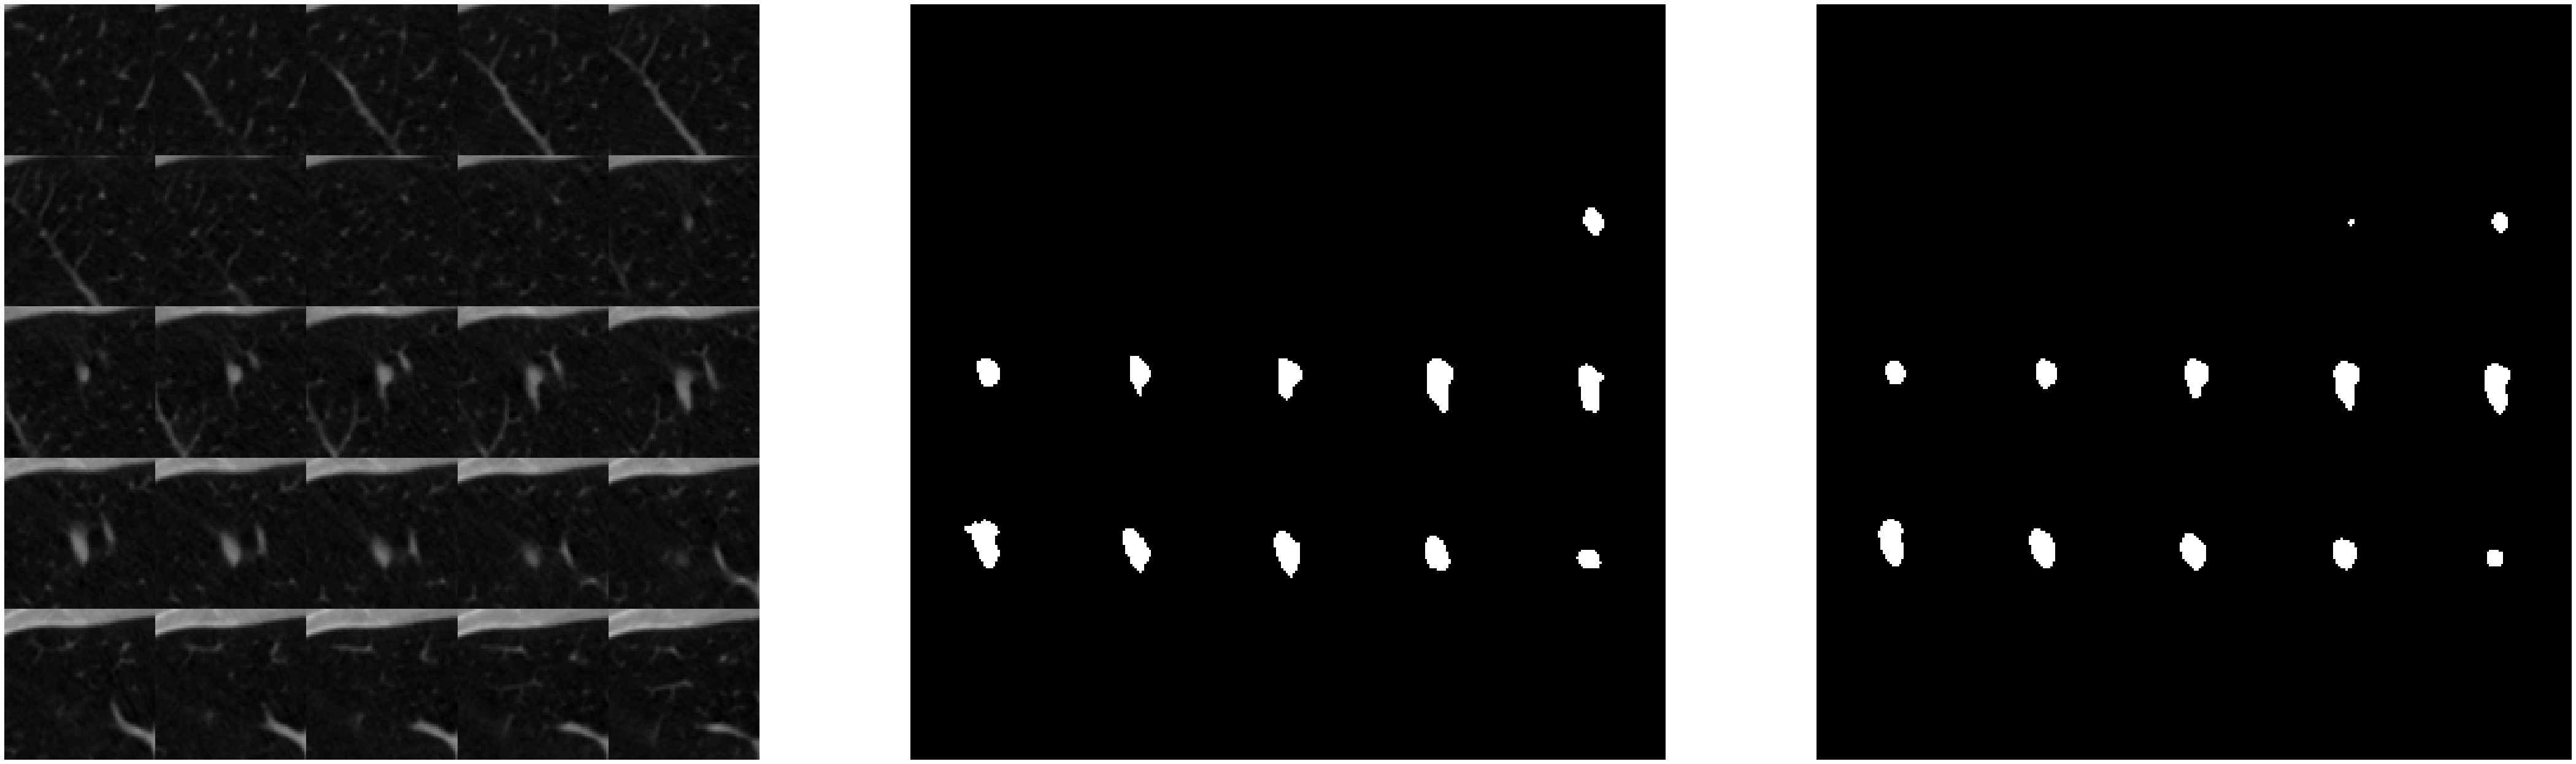

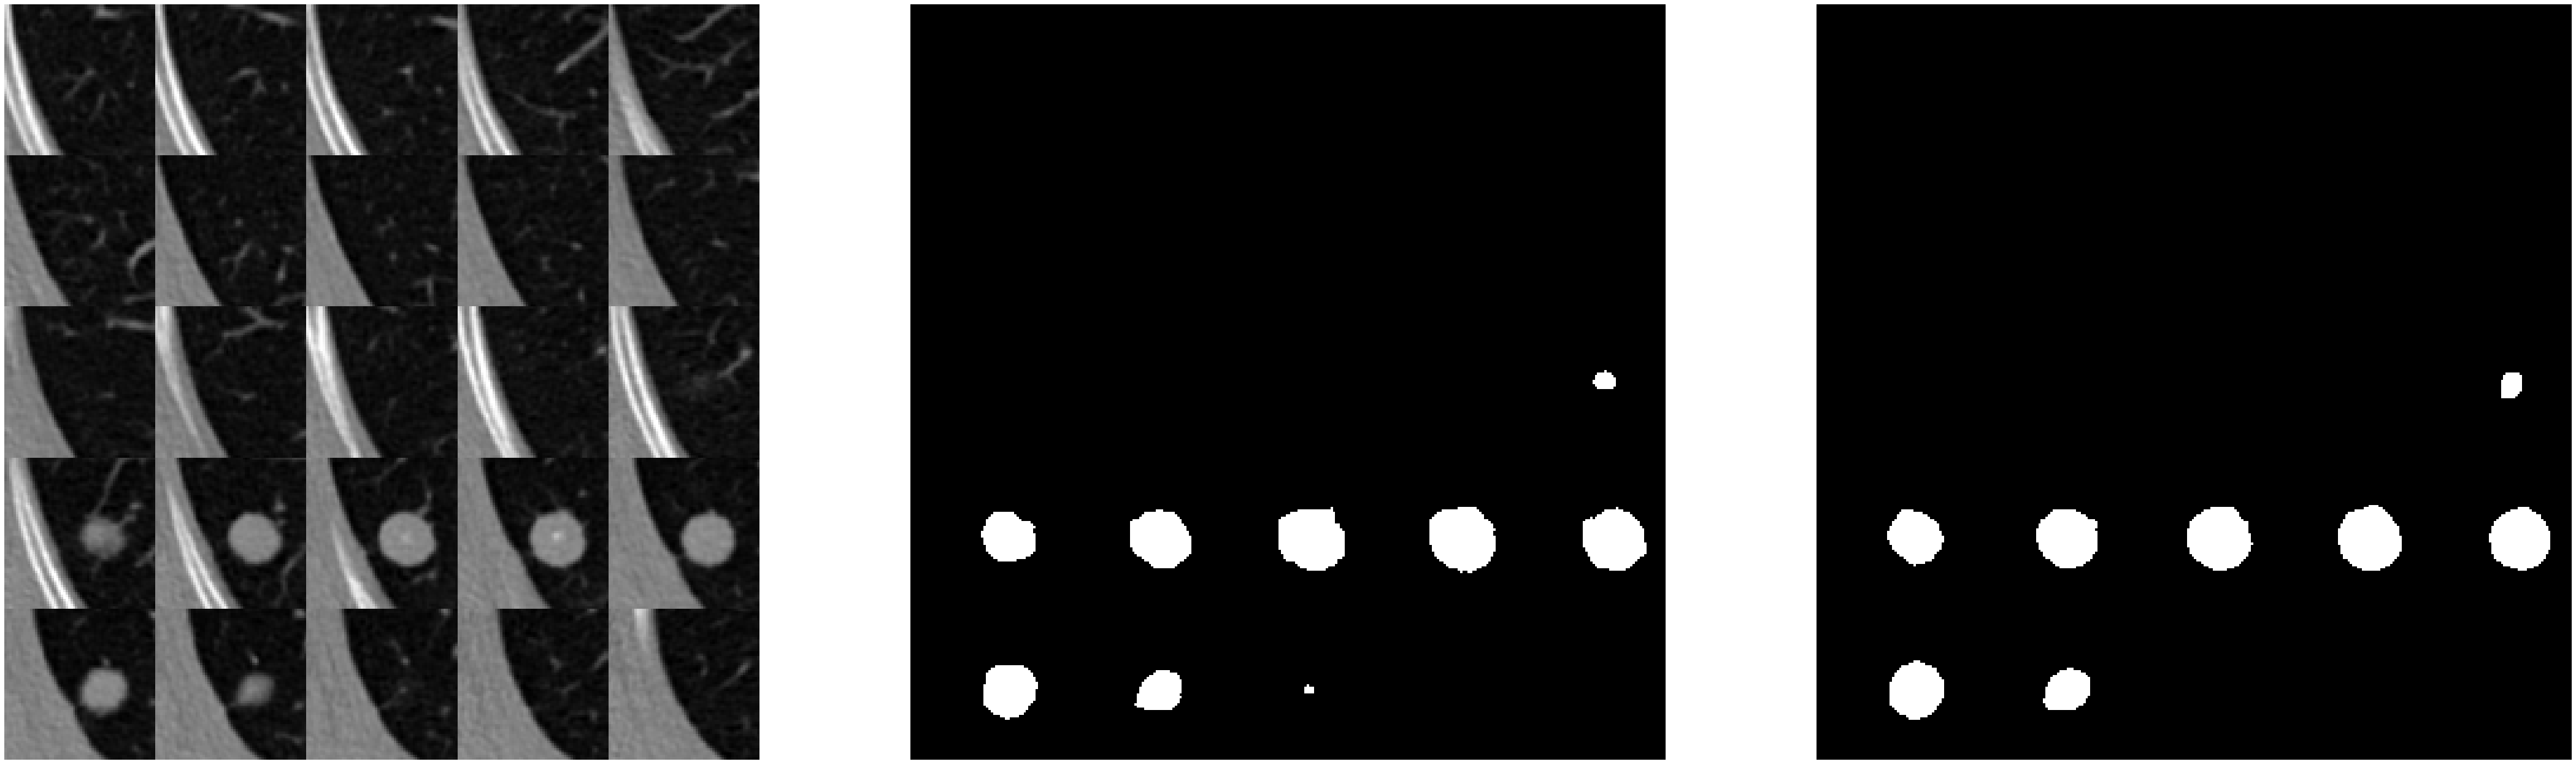

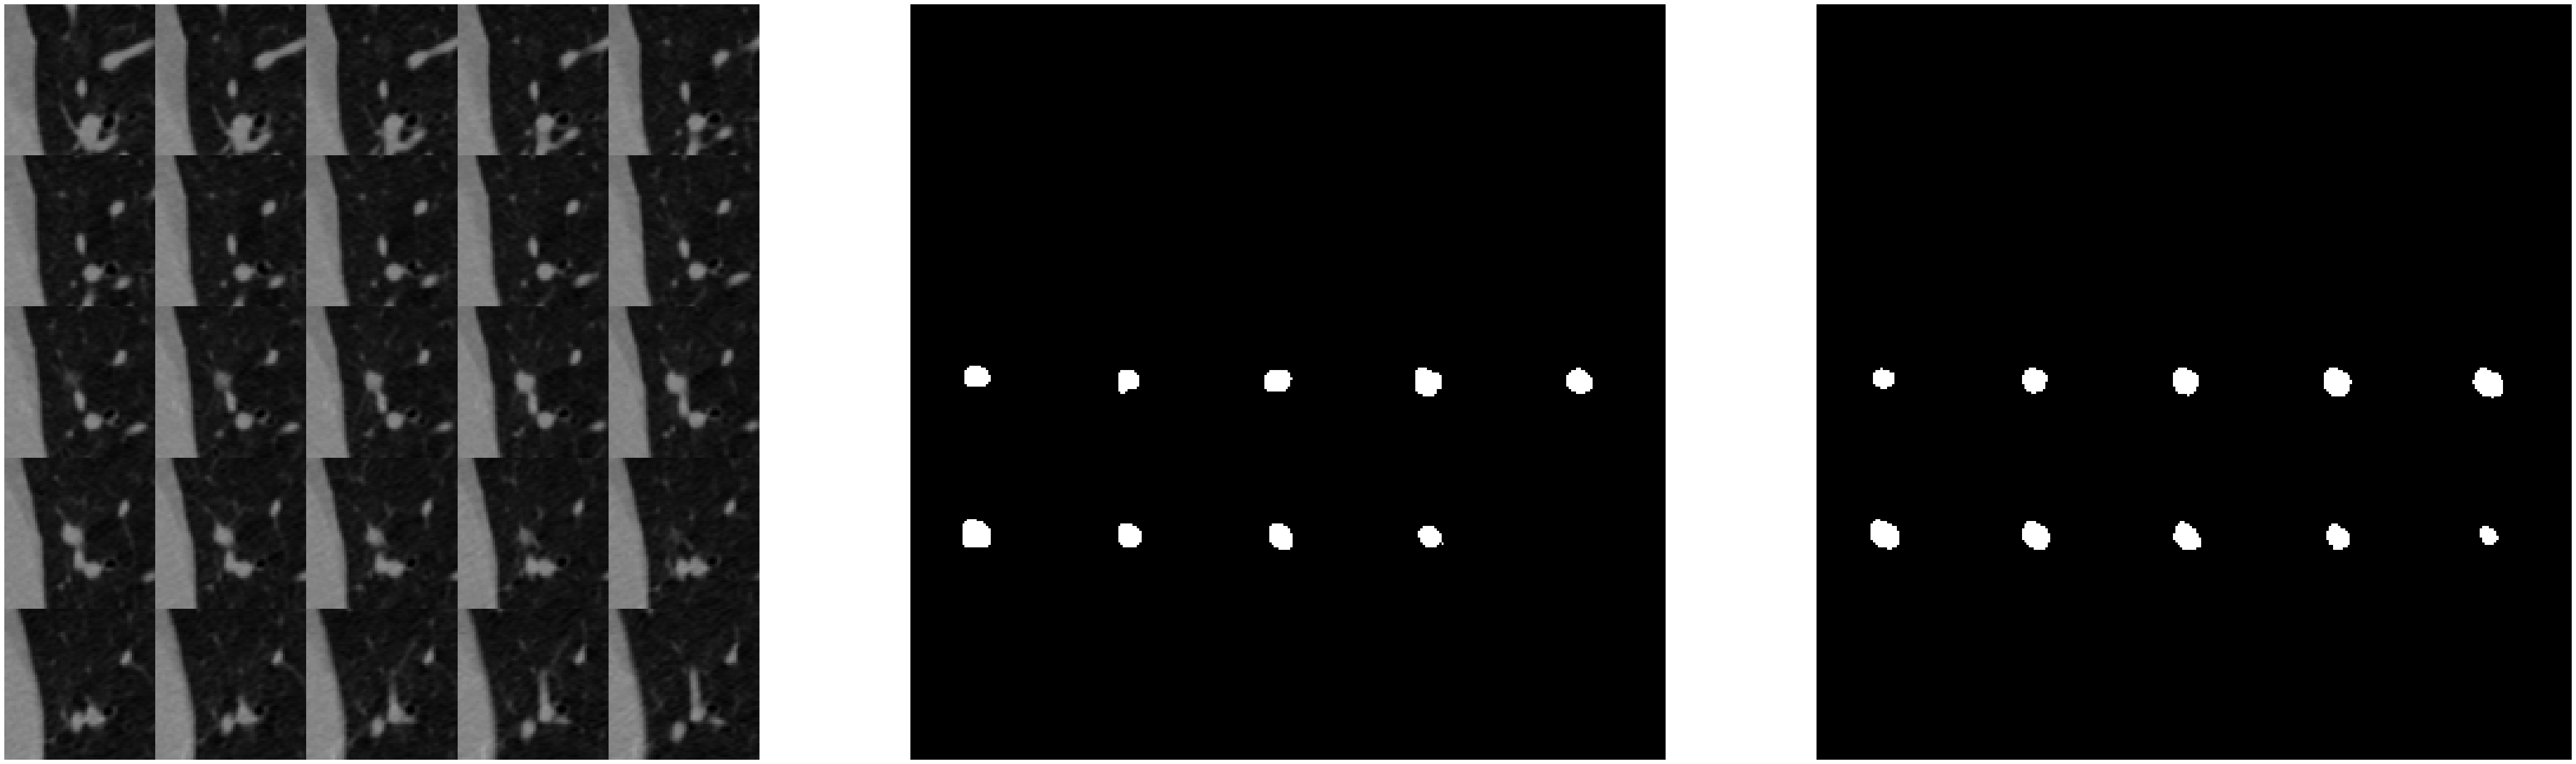

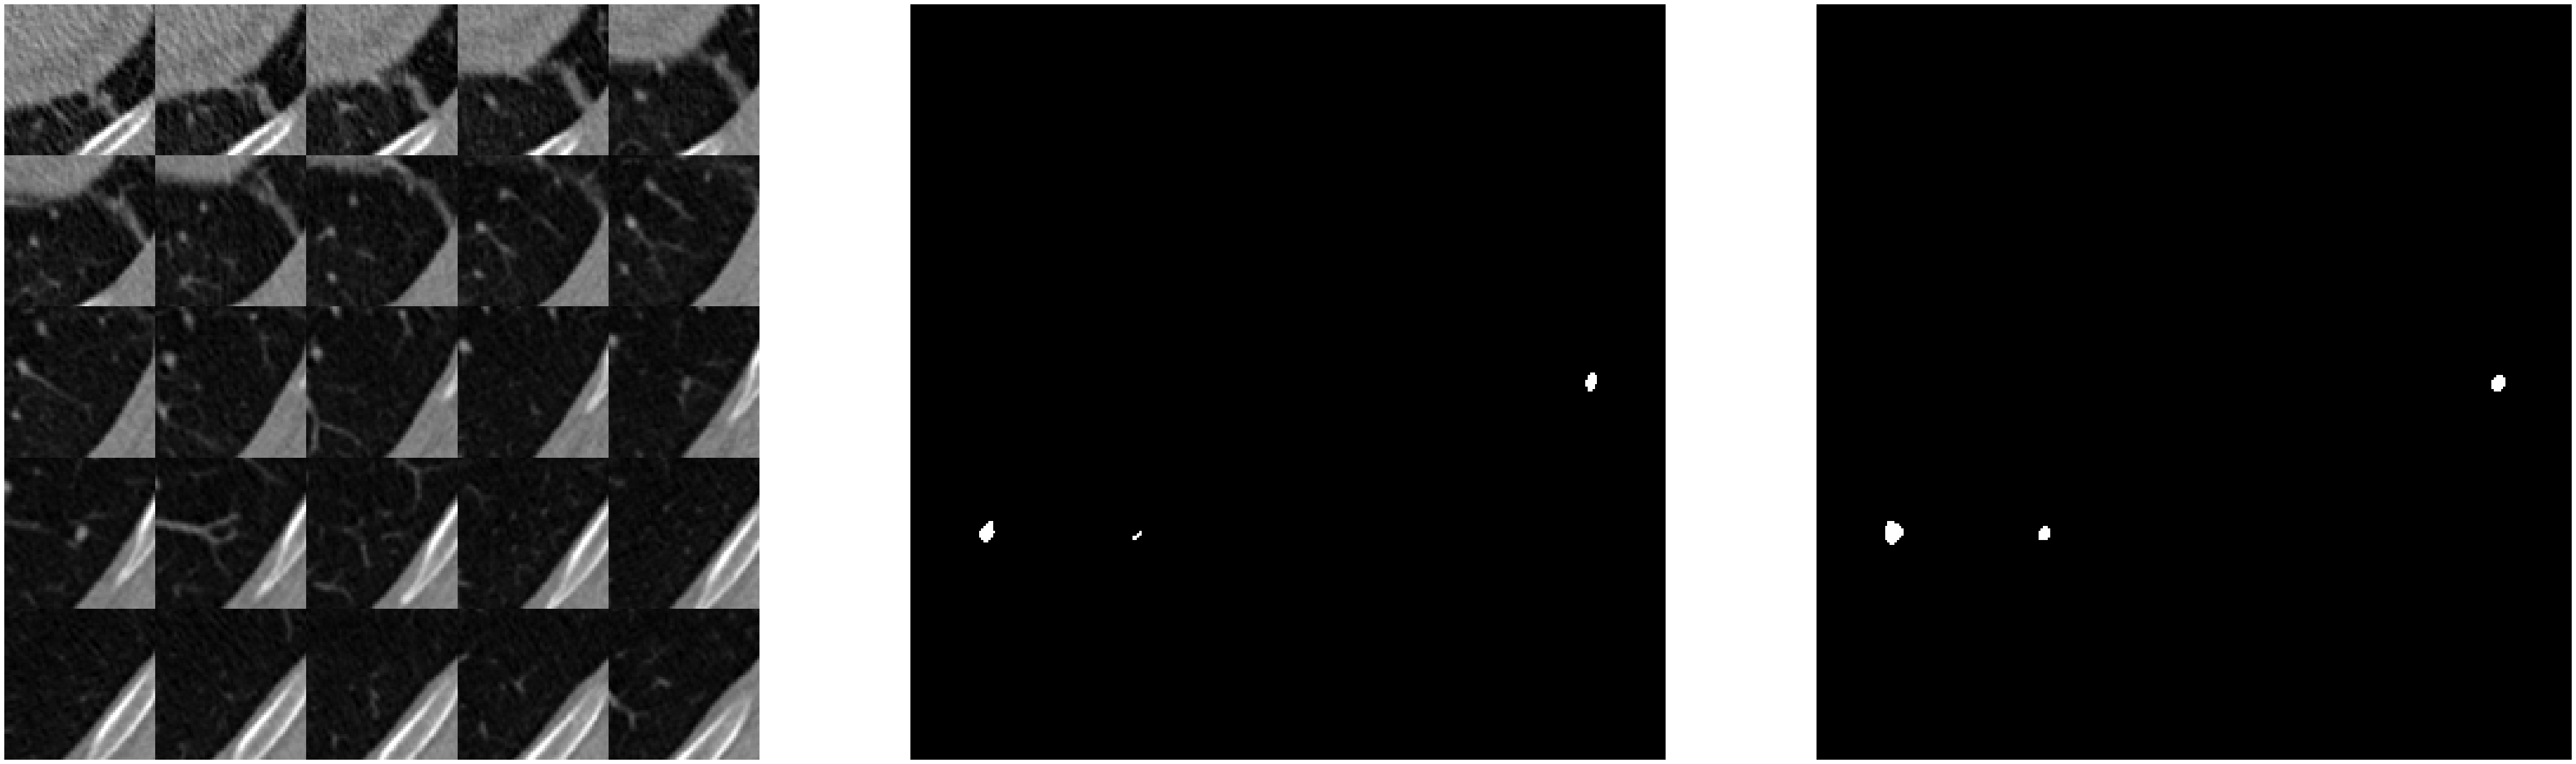

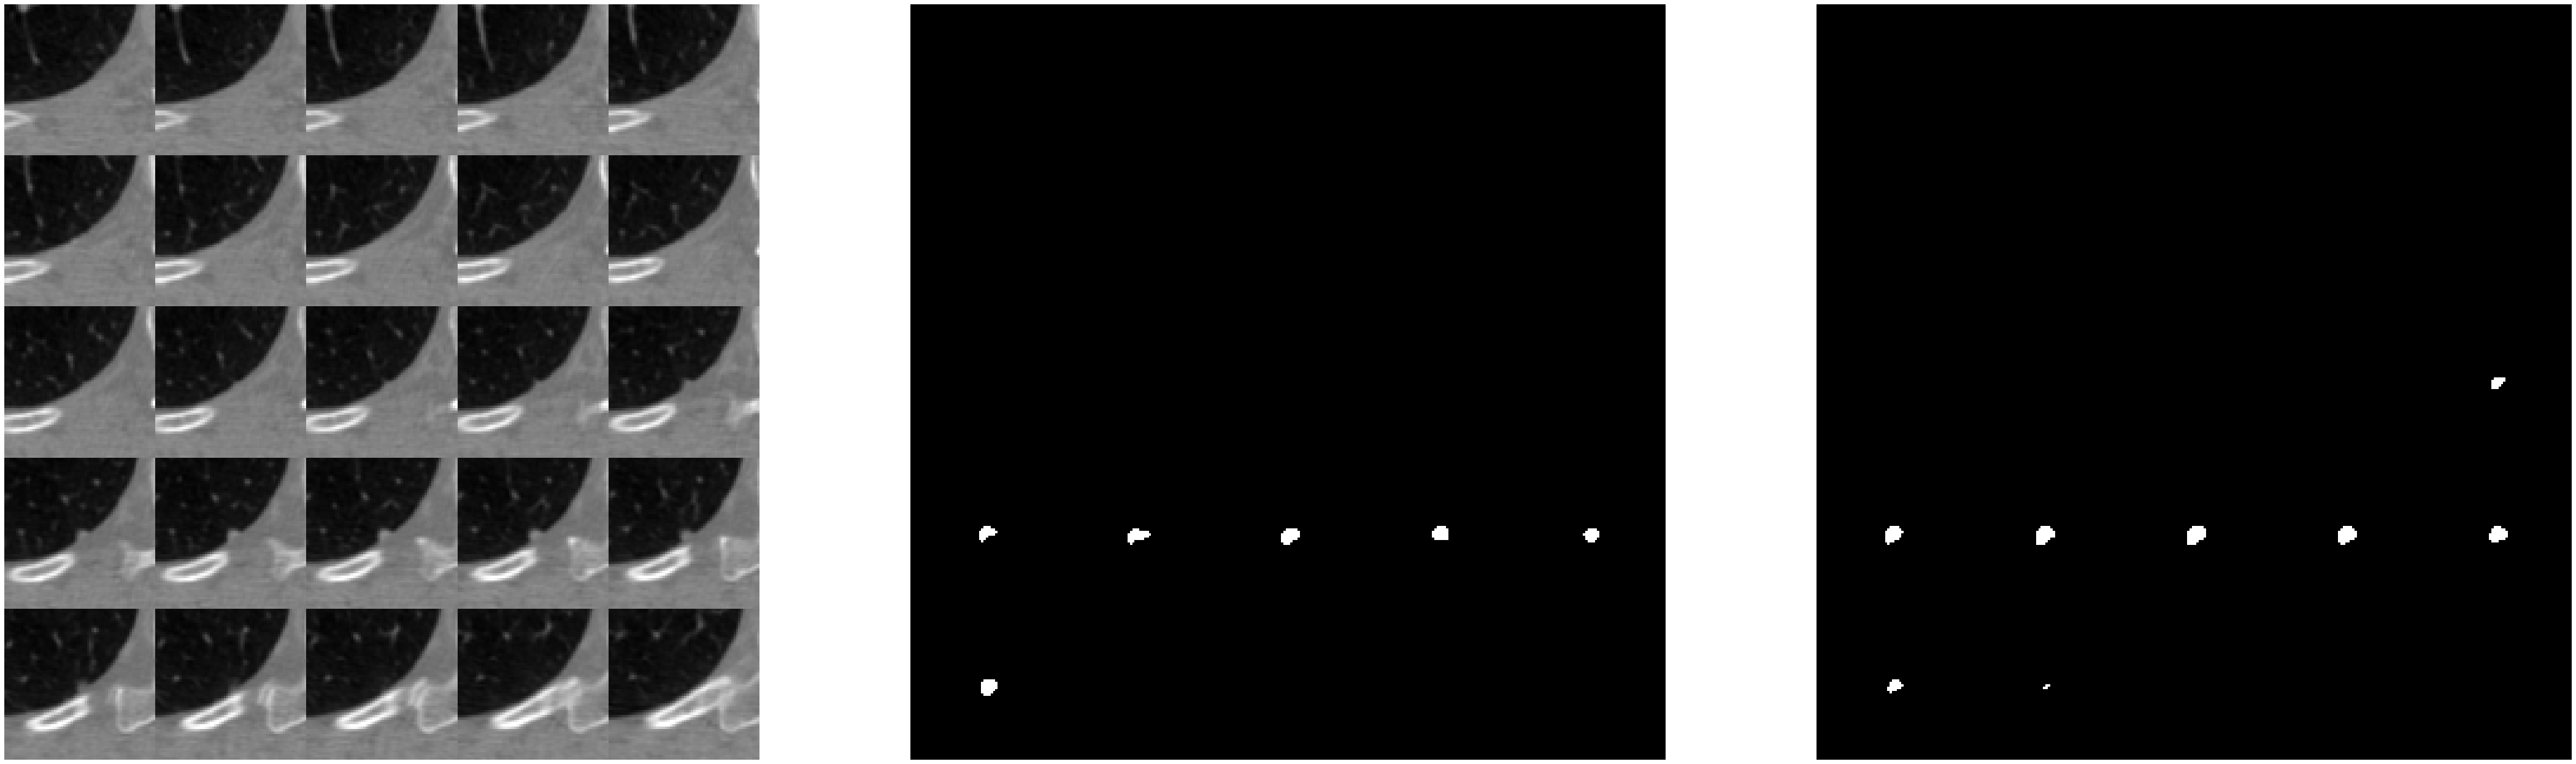

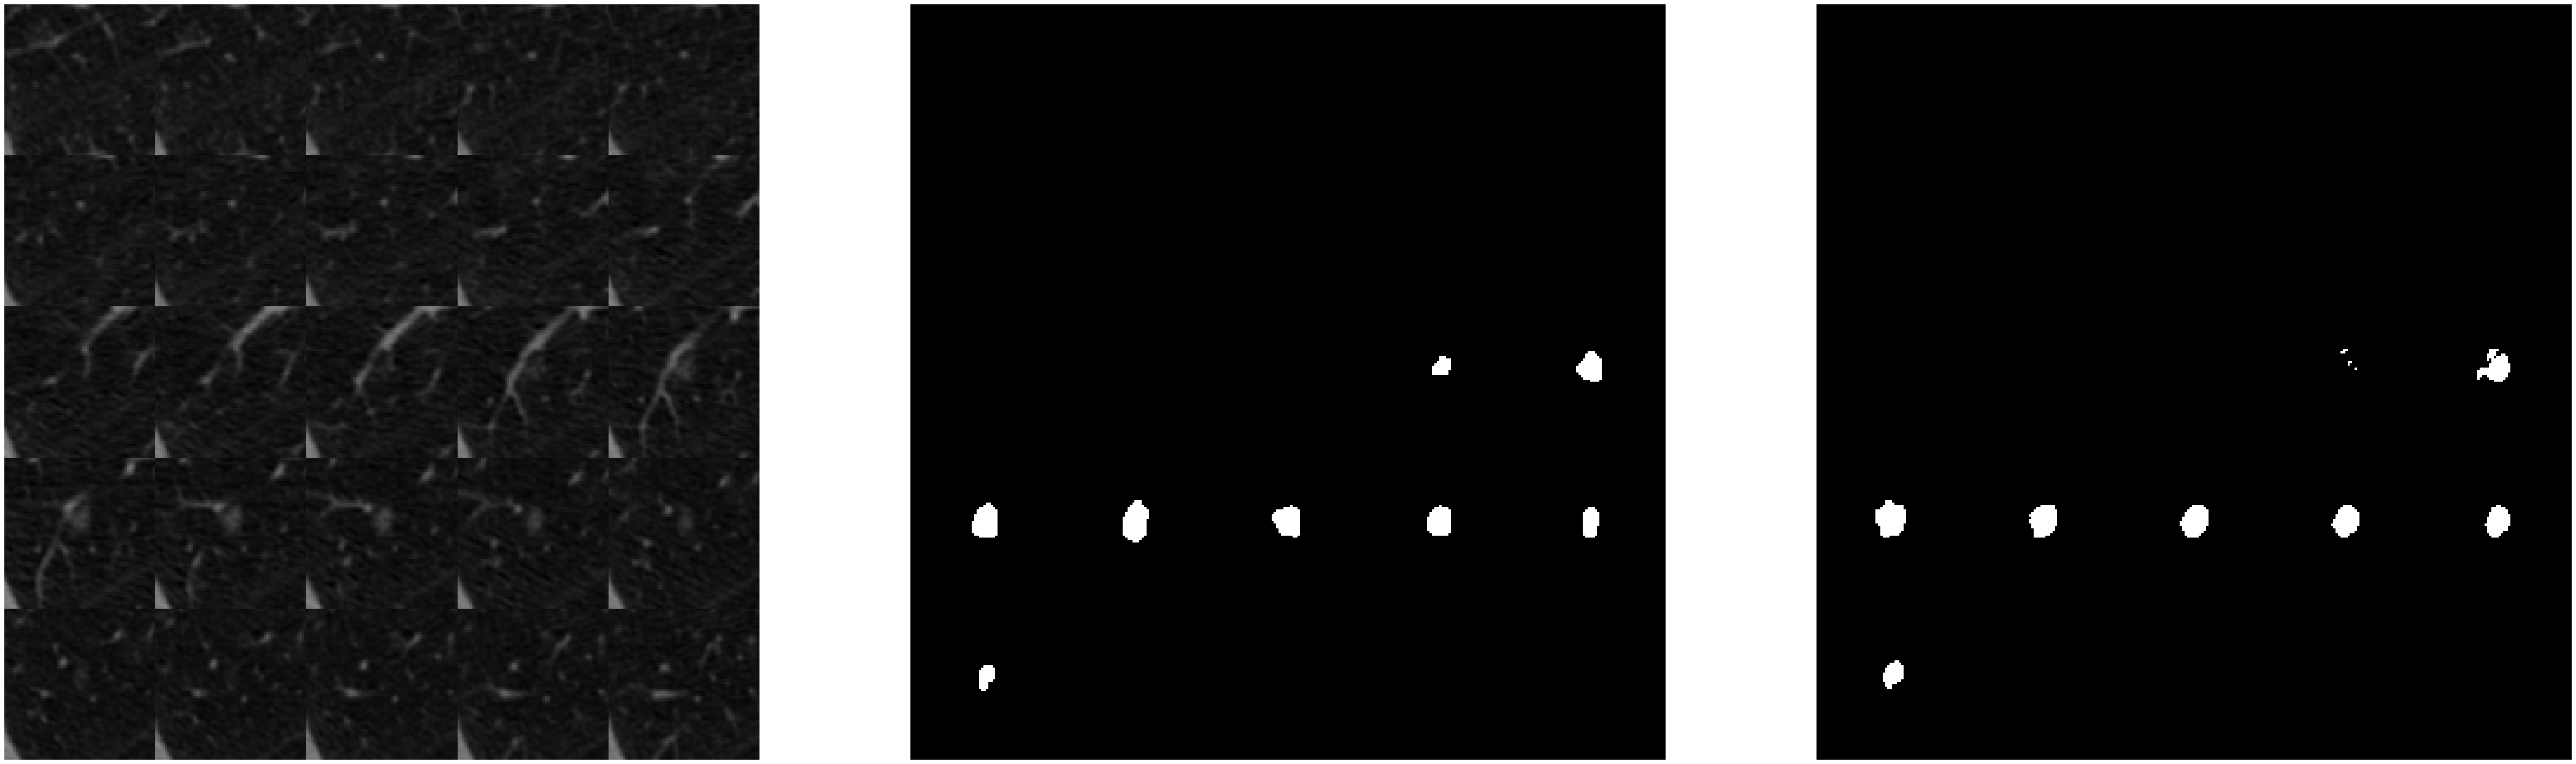

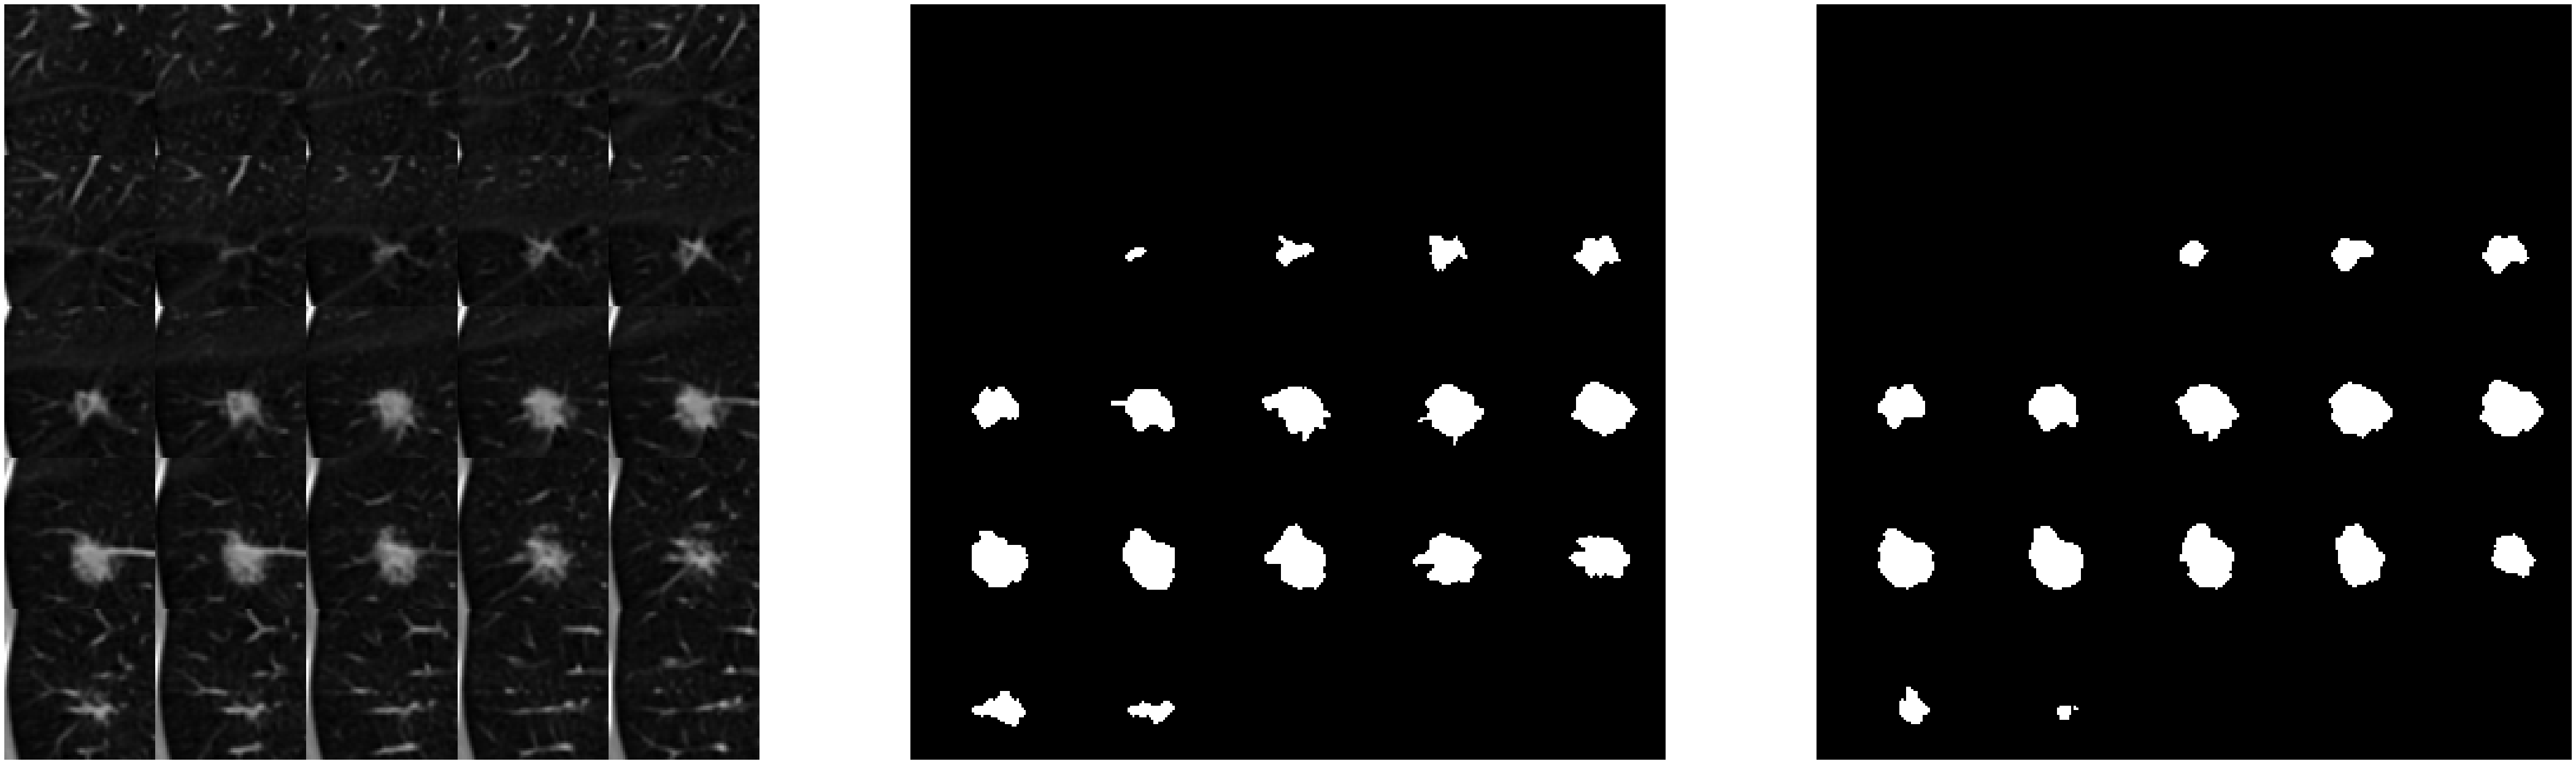

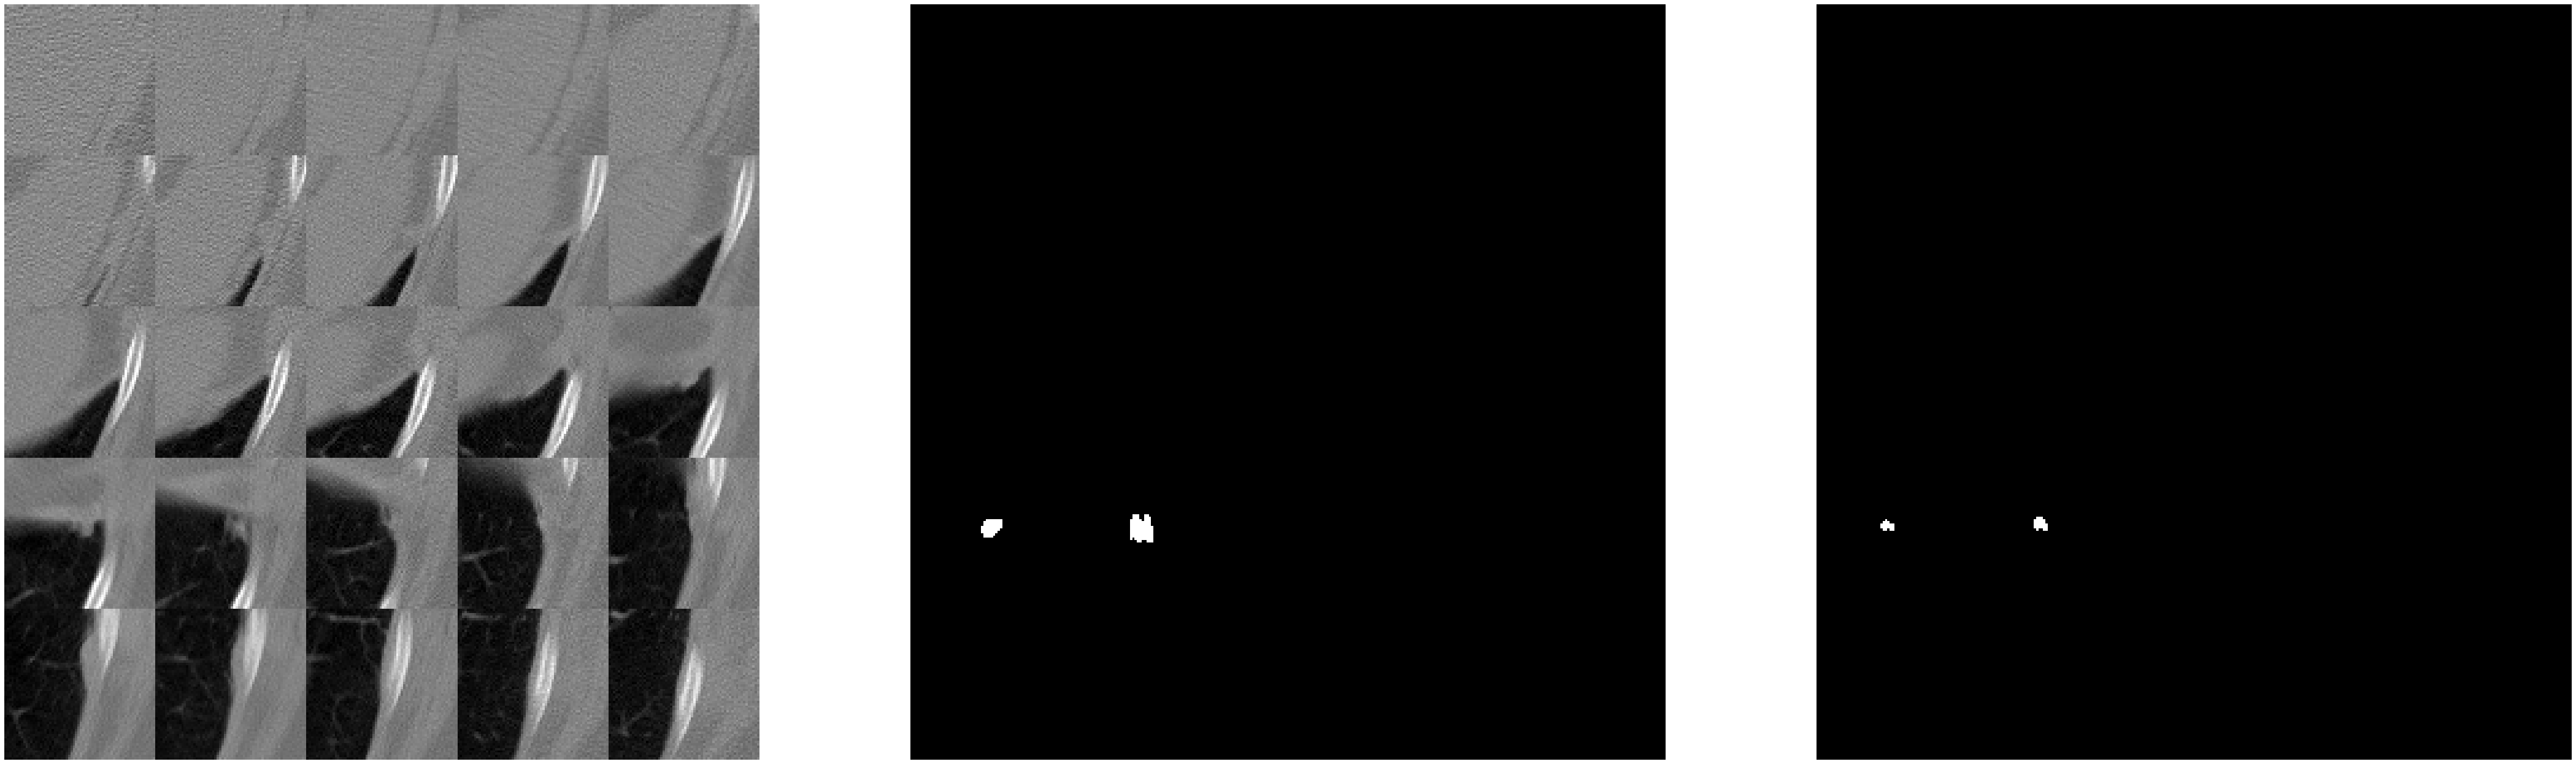

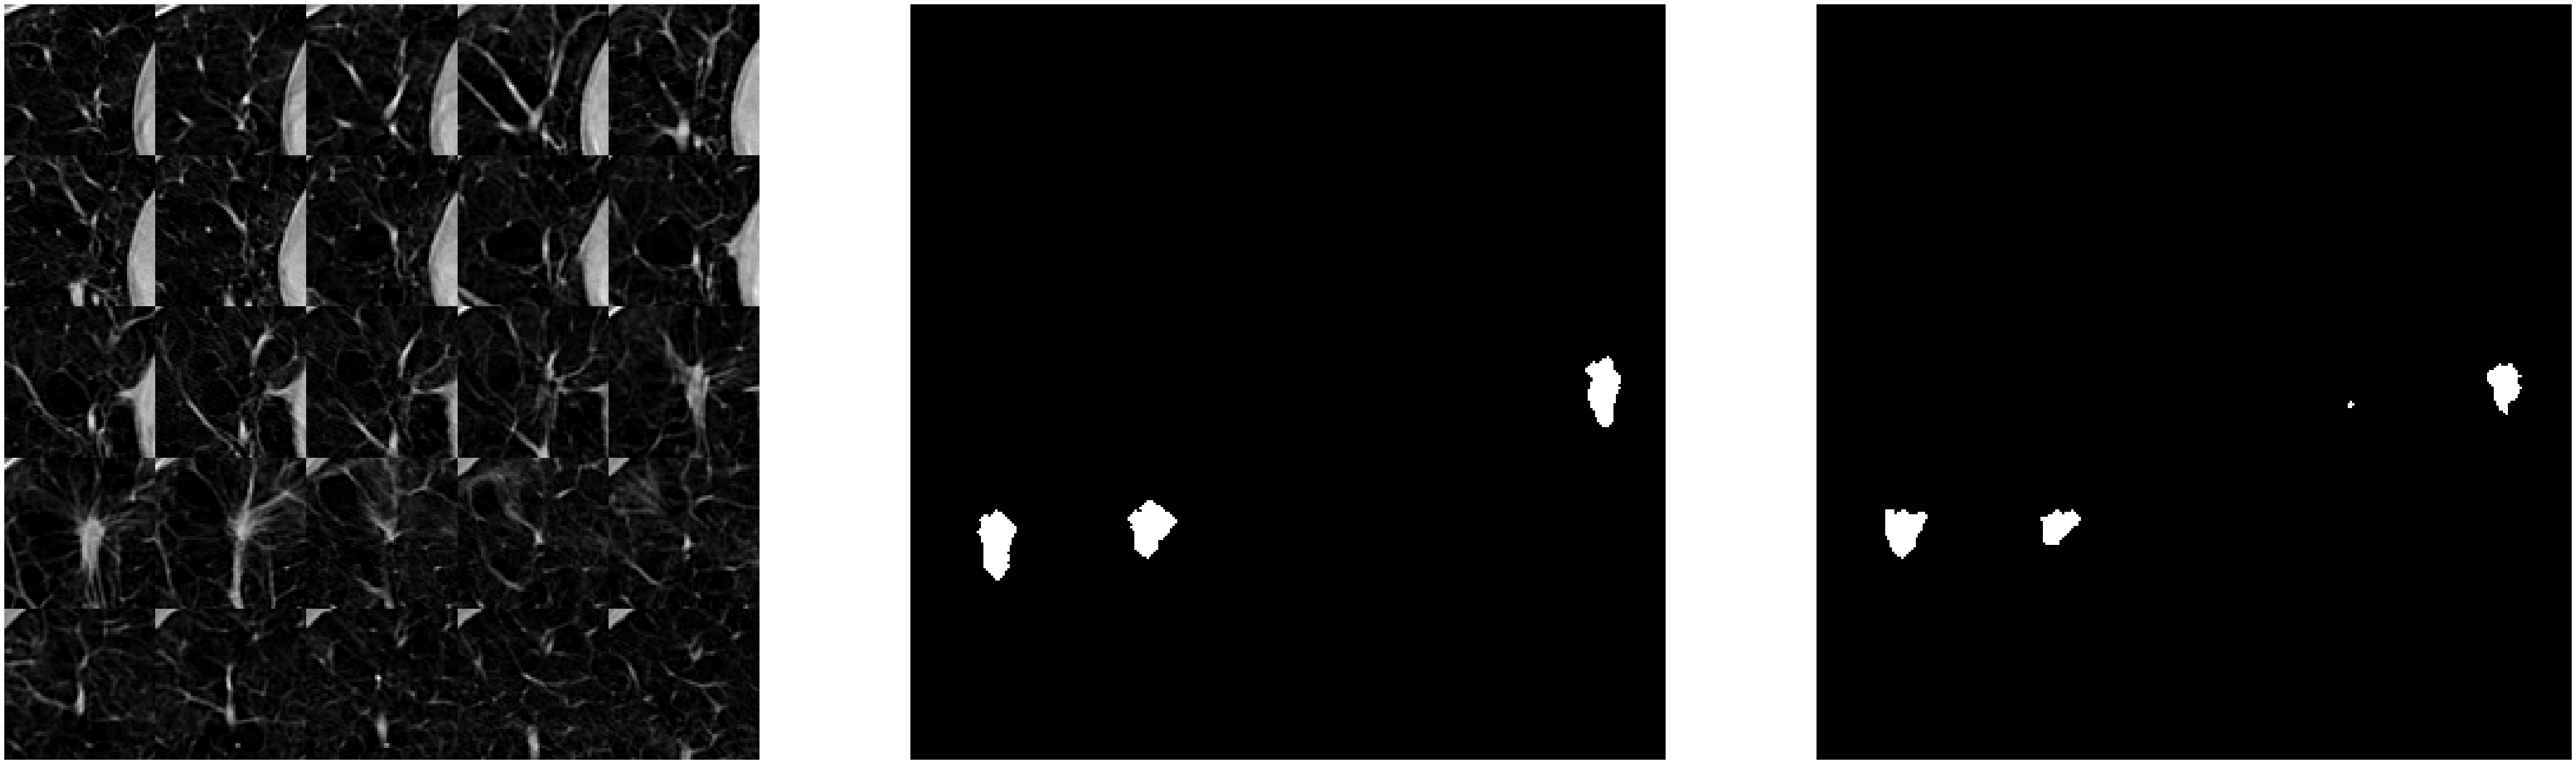

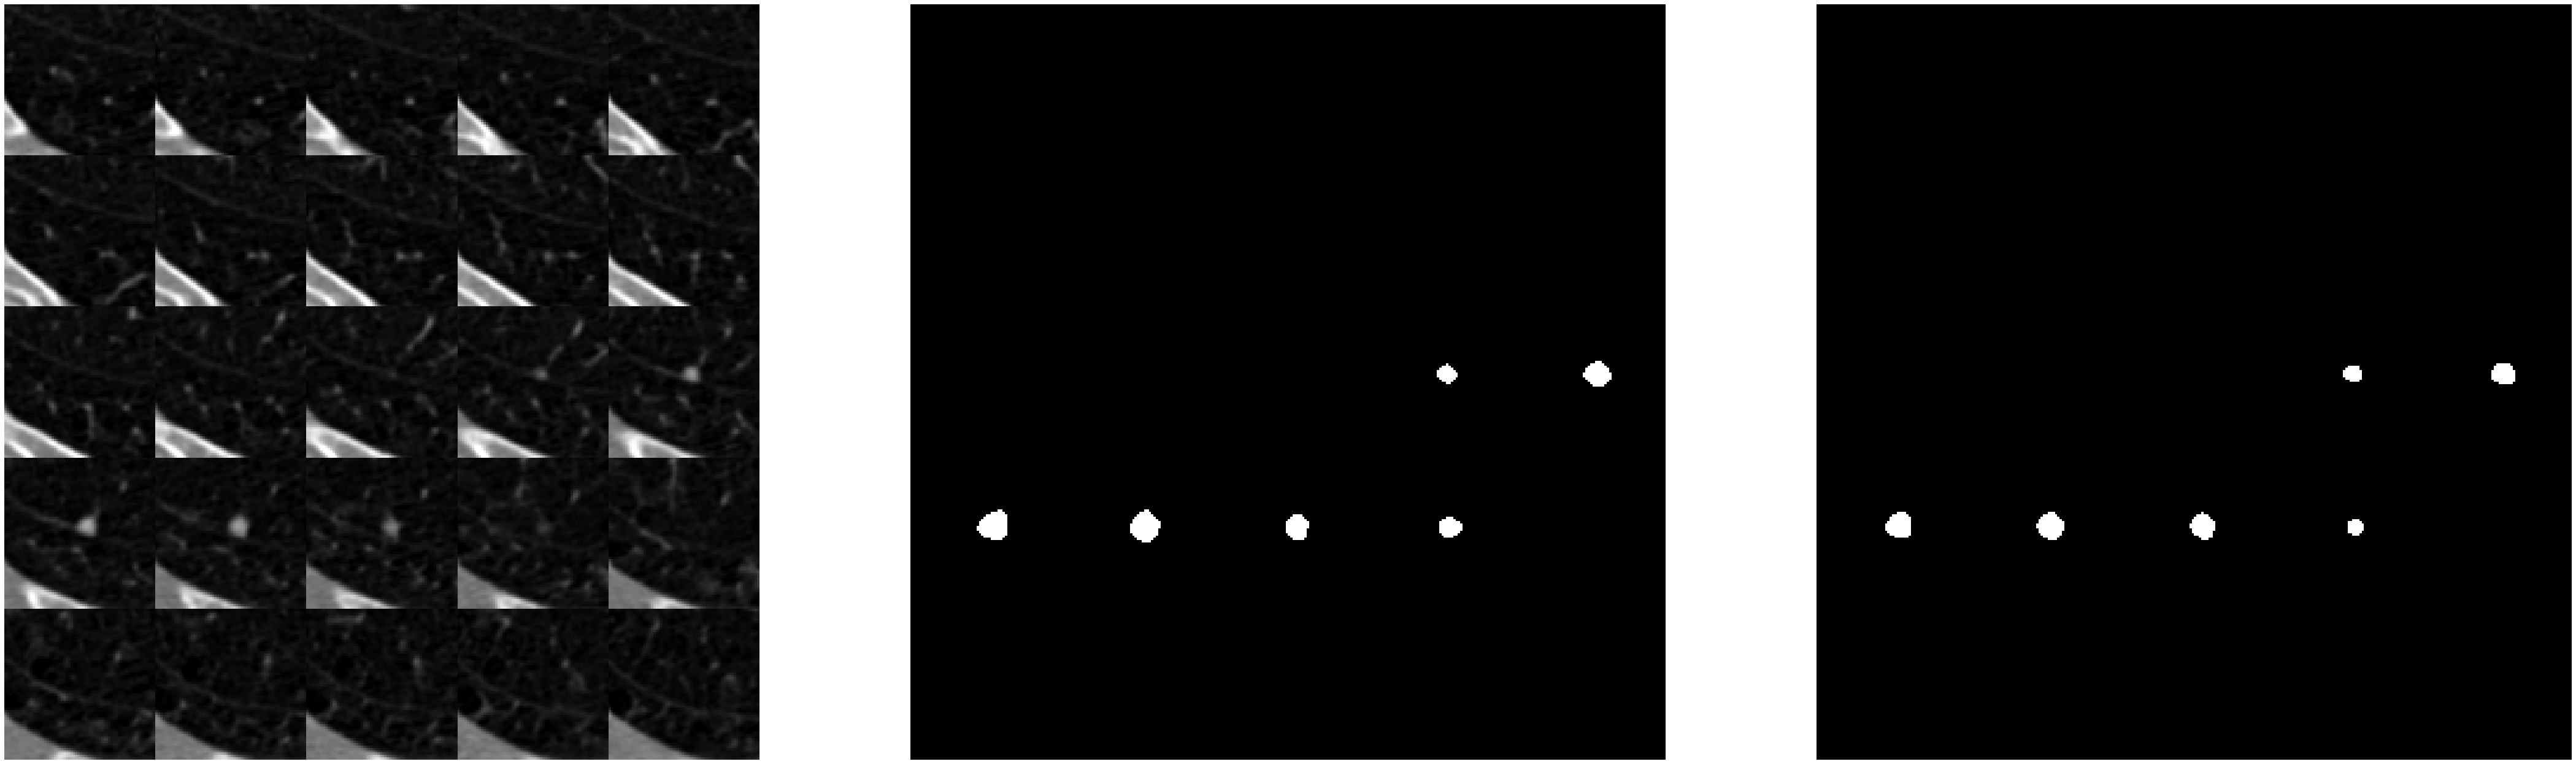

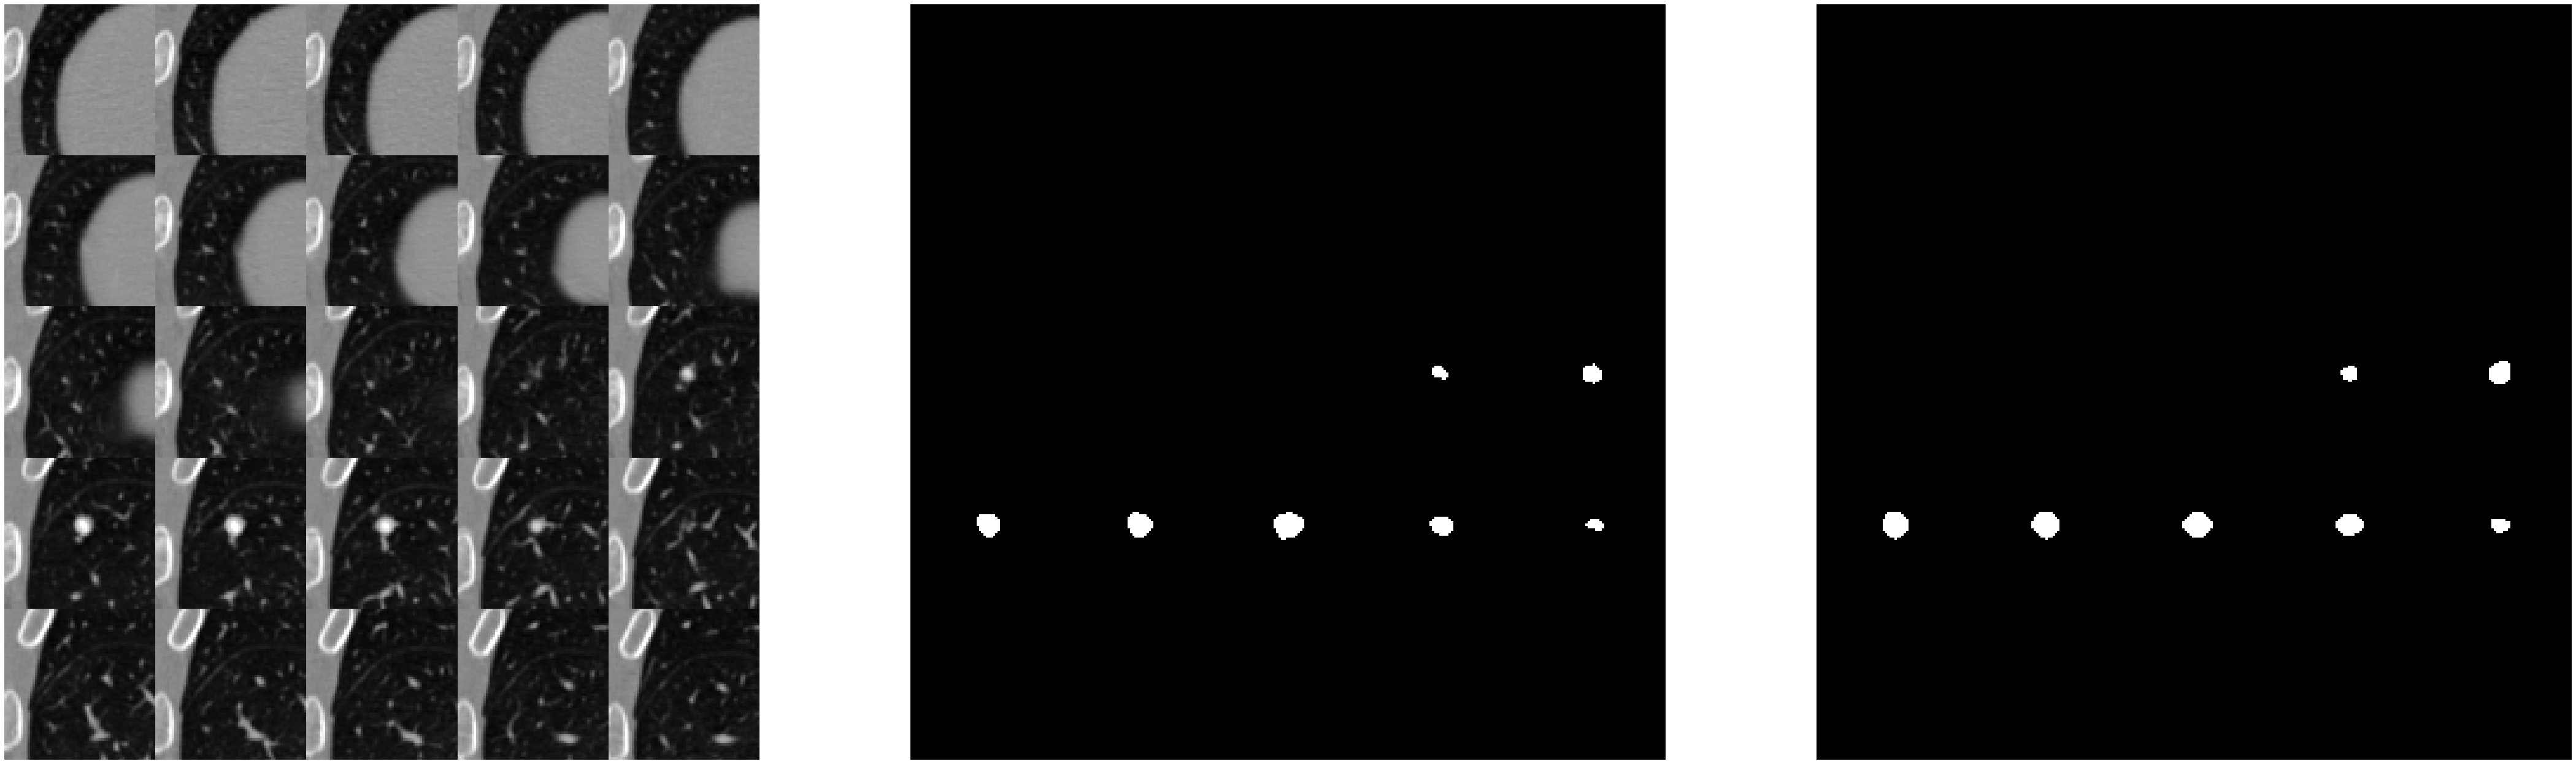

In [12]:
p_test = np.squeeze(p_test)
for i in range(0, x_test.shape[0], 80):
    plot_image_truth_prediction(x_test[i], y_test[i], p_test[i], rows=5, cols=5)

# Train from scratch

In [3]:
args.suffix = 'random'
conf = ncs_config(args)
conf.display()


Configurations:
arch                           Vnet
batch_size                     16
data                           /mnt/dataset/shared/zongwei/LIDC
exp_name                       Vnet-random
input_cols                     64
input_deps                     32
input_rows                     64
logs_path                      models/ncs/run_1/logs
lr                             0.001
max_queue_size                 1
model_path                     models/ncs/run_1
nb_epoch                       10000
optimizer                      <keras.optimizers.Adam object at 0x7f46be29f2e8>
patience                       50
use_multiprocessing            False
verbose                        1
weights                        None
workers                        1


### Train

In [4]:
model = unet_model_3d((1,conf.input_rows,conf.input_cols,conf.input_deps), batch_normalization=True)
if conf.weights is not None:
    print("[INFO] Load pre-trained weights from {}".format(conf.weights))
    model.load_weights(conf.weights)
model, callbacks = model_setup(model, conf, task=args.task)

while conf.batch_size > 1:
    # To find a largest batch size that can be fit into GPU
    try:
        model.fit(x_train, y_train,
                  validation_data=(x_valid, y_valid),
                  batch_size=conf.batch_size,
                  epochs=conf.nb_epoch, 
                  verbose=conf.verbose, 
                  shuffle=True,
                  callbacks=callbacks)
        break
    except tf.errors.ResourceExhaustedError as e:
        conf.batch_size = int(conf.batch_size - 2)
        print("\n> Batch size = {}".format(conf.batch_size))

Train on 4082 samples, validate on 3126 samples
Epoch 1/10000
  16/4082 [..............................] - ETA: 56:02 - loss: 0.9774 - mean_iou: 0.0000e+00 - dice_coef: 0.0226
> Batch size = 14
Train on 4082 samples, validate on 3126 samples
Epoch 1/10000
4082/4082 [==============================] - 698s 171ms/step - loss: 0.4830 - mean_iou: 0.5855 - dice_coef: 0.5170 - val_loss: 0.6761 - val_mean_iou: 0.6377 - val_dice_coef: 0.3239

Epoch 00001: val_loss improved from inf to 0.67613, saving model to models/ncs/run_1/Vnet-random.h5
Epoch 2/10000
4082/4082 [==============================] - 693s 170ms/step - loss: 0.2768 - mean_iou: 0.6501 - dice_coef: 0.7232 - val_loss: 0.4000 - val_mean_iou: 0.6758 - val_dice_coef: 0.6000

Epoch 00002: val_loss improved from 0.67613 to 0.40000, saving model to models/ncs/run_1/Vnet-random.h5
Epoch 3/10000
4082/4082 [==============================] - 695s 170ms/step - loss: 0.2300 - mean_iou: 0.6940 - dice_coef: 0.7700 - val_loss: 0.3363 - val_mean_iou


Epoch 00026: val_loss did not improve from 0.22695
Epoch 27/10000
4082/4082 [==============================] - 693s 170ms/step - loss: 0.0714 - mean_iou: 0.8347 - dice_coef: 0.9286 - val_loss: 0.2395 - val_mean_iou: 0.8355 - val_dice_coef: 0.7605

Epoch 00027: val_loss did not improve from 0.22695
Epoch 28/10000
4082/4082 [==============================] - 693s 170ms/step - loss: 0.0693 - mean_iou: 0.8363 - dice_coef: 0.9307 - val_loss: 0.2315 - val_mean_iou: 0.8370 - val_dice_coef: 0.7685

Epoch 00028: val_loss did not improve from 0.22695
Epoch 29/10000
4082/4082 [==============================] - 693s 170ms/step - loss: 0.0666 - mean_iou: 0.8378 - dice_coef: 0.9334 - val_loss: 0.2313 - val_mean_iou: 0.8385 - val_dice_coef: 0.7687

Epoch 00029: val_loss did not improve from 0.22695
Epoch 30/10000
4082/4082 [==============================] - 693s 170ms/step - loss: 0.0661 - mean_iou: 0.8392 - dice_coef: 0.9339 - val_loss: 0.2370 - val_mean_iou: 0.8398 - val_dice_coef: 0.7630

Epoch 0

### Test

In [4]:
model = unet_model_3d((1,conf.input_rows,conf.input_cols,conf.input_deps), batch_normalization=True)
print("[INFO] Load trained model from {}".format( os.path.join(conf.model_path, conf.exp_name+".h5") ))
model.load_weights( os.path.join(conf.model_path, conf.exp_name+".h5") )

p_test = segmentation_model_evaluation(model=model, config=conf, x=x_test, y=y_test, note=conf.exp_name)

[INFO] Load trained model from models/ncs/run_1/Vnet-random.h5
852/852 [==============================] - 1102s 1s/step
[INFO] Vnet-random
x:  (852, 1, 64, 64, 32) | 0.0 ~ 1.0
y:  (852, 1, 64, 64, 32) | 0.0 ~ 1.0
p:  (852, 1, 64, 64, 32) | 0.0 ~ 1.0
[BIN]  Dice = 73.82%
[BIN]  IoU  = 58.50%
[EVAL] Dice = 72.49%
[EVAL] IoU  = 75.22%


### Visualization

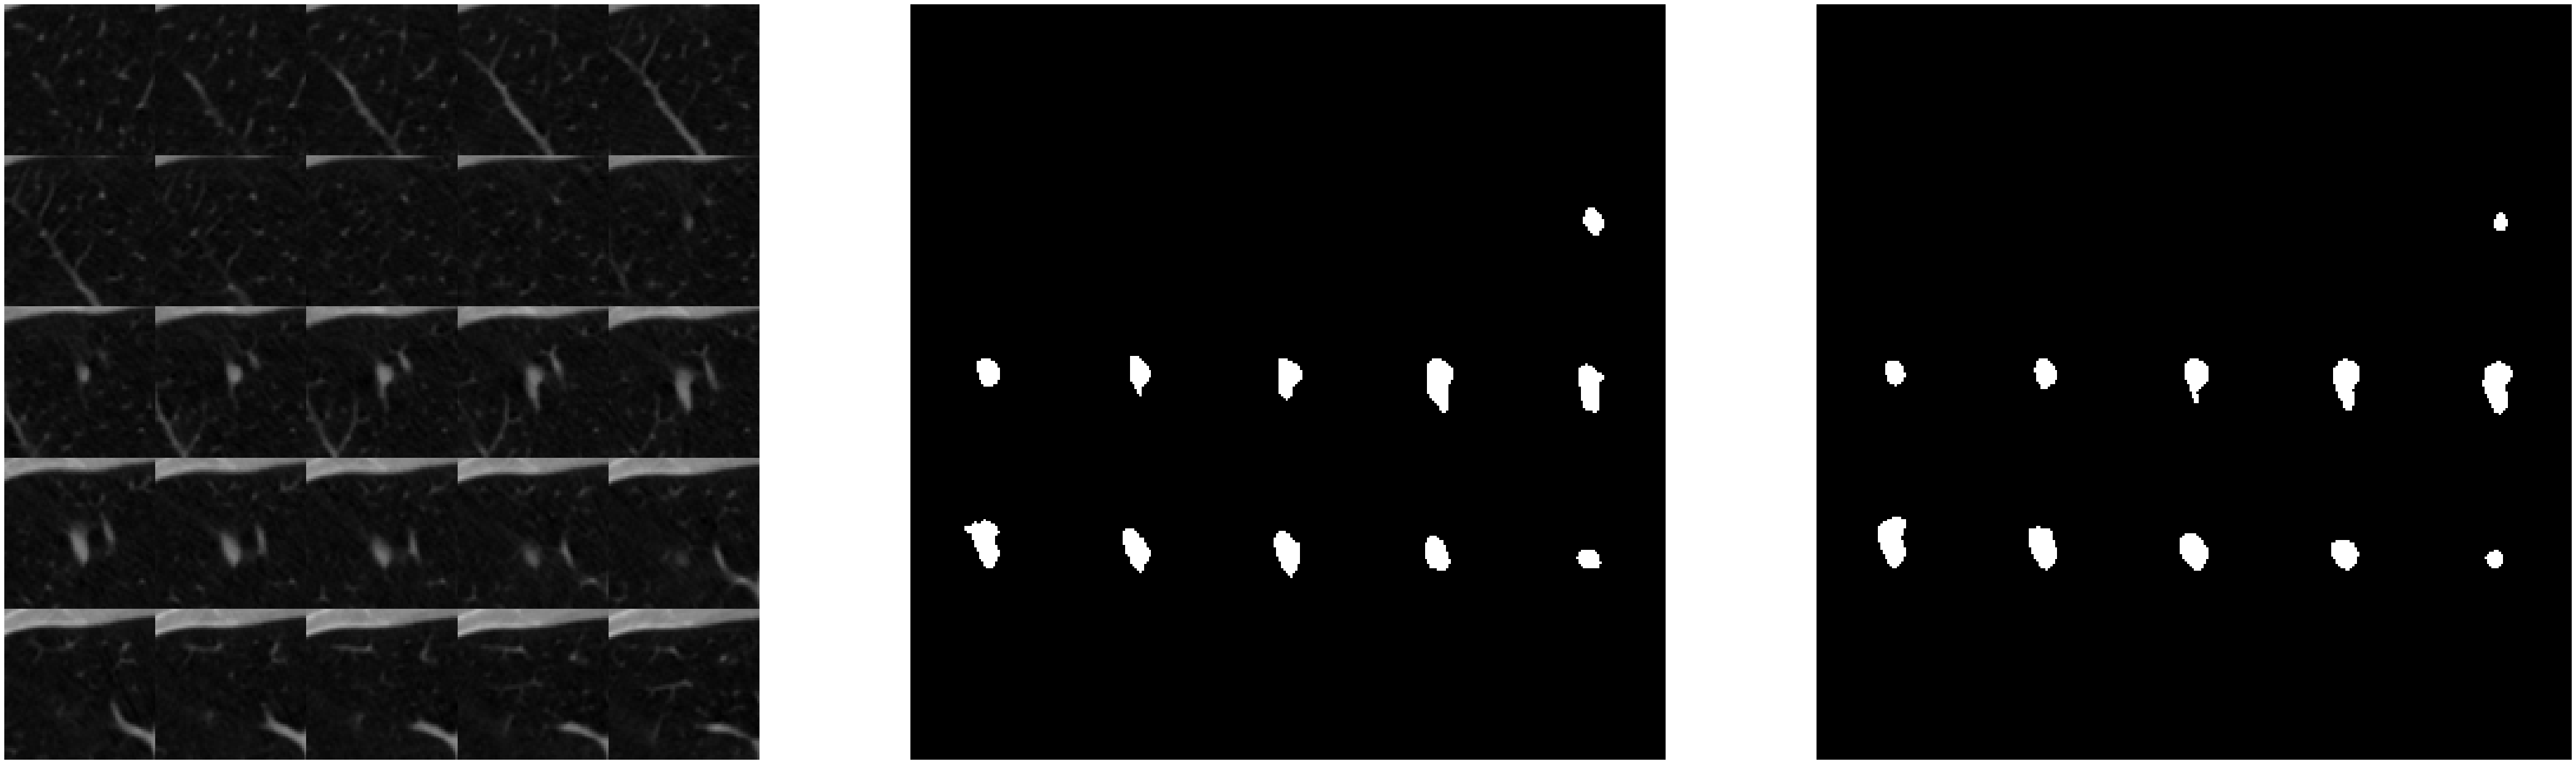

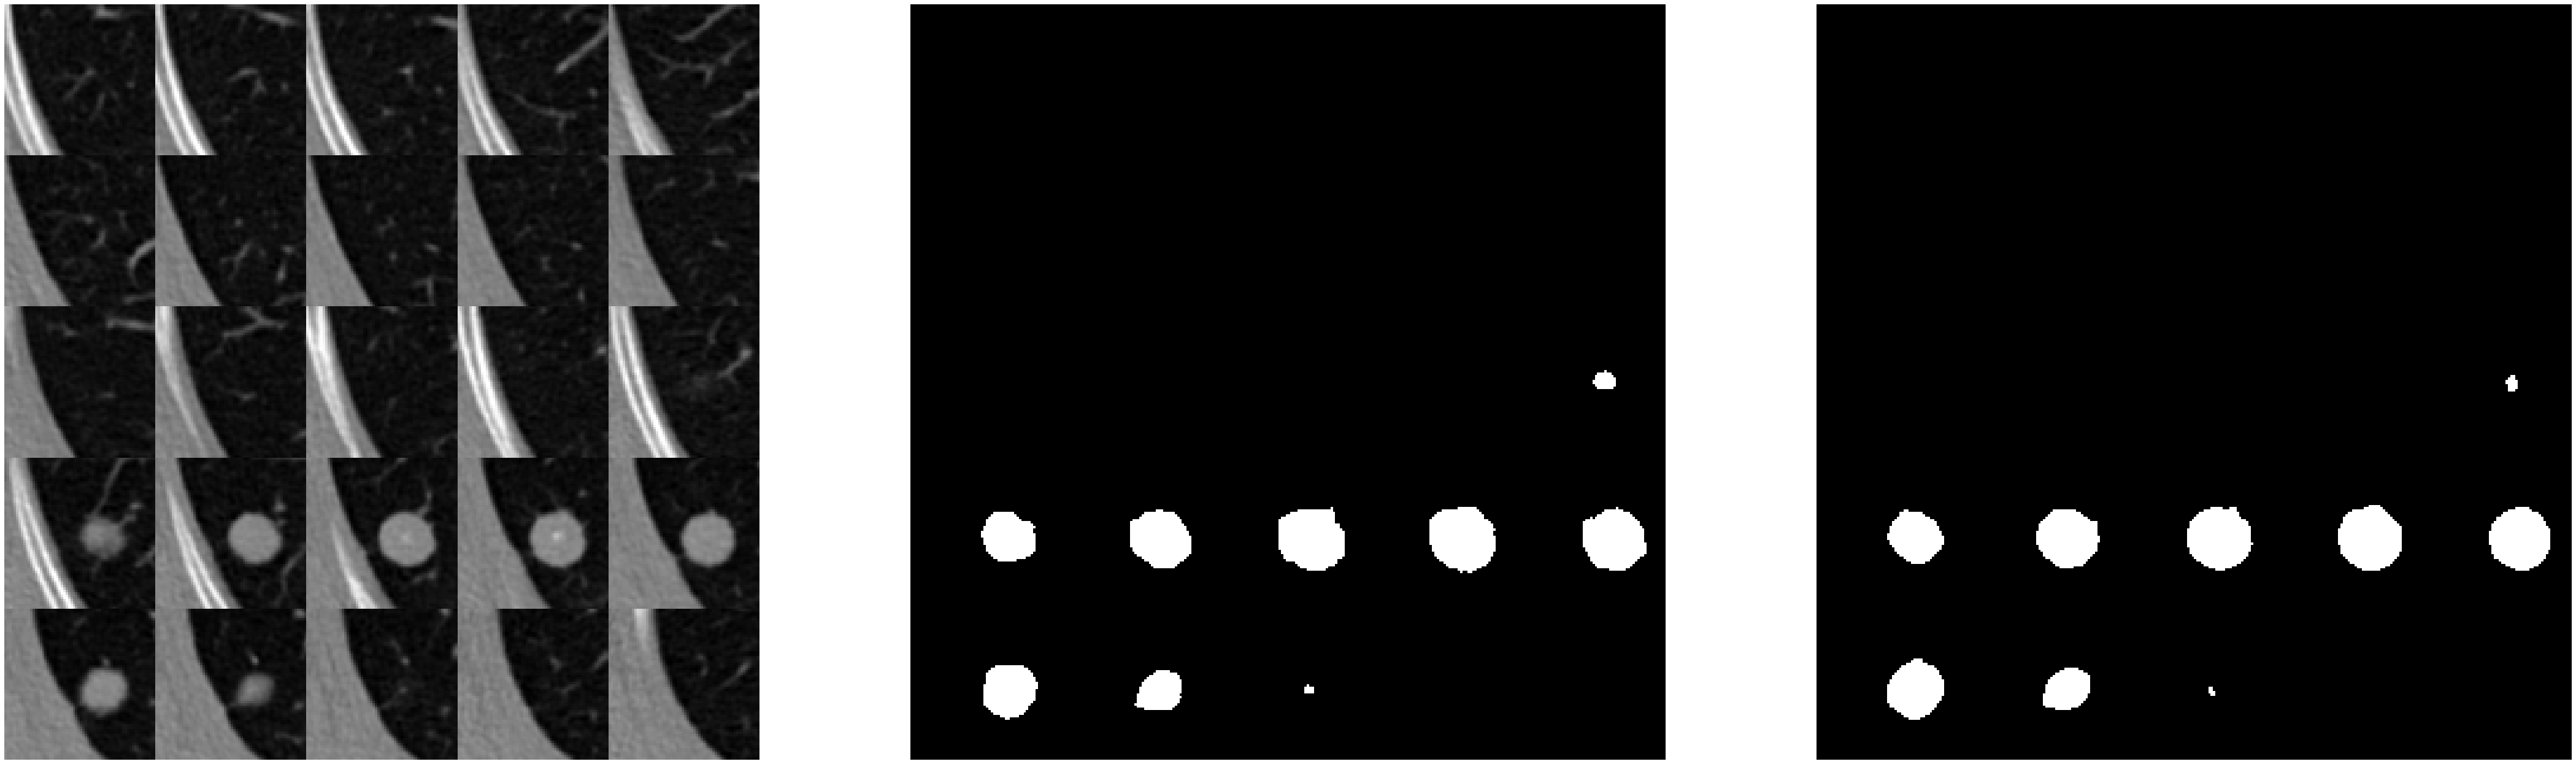

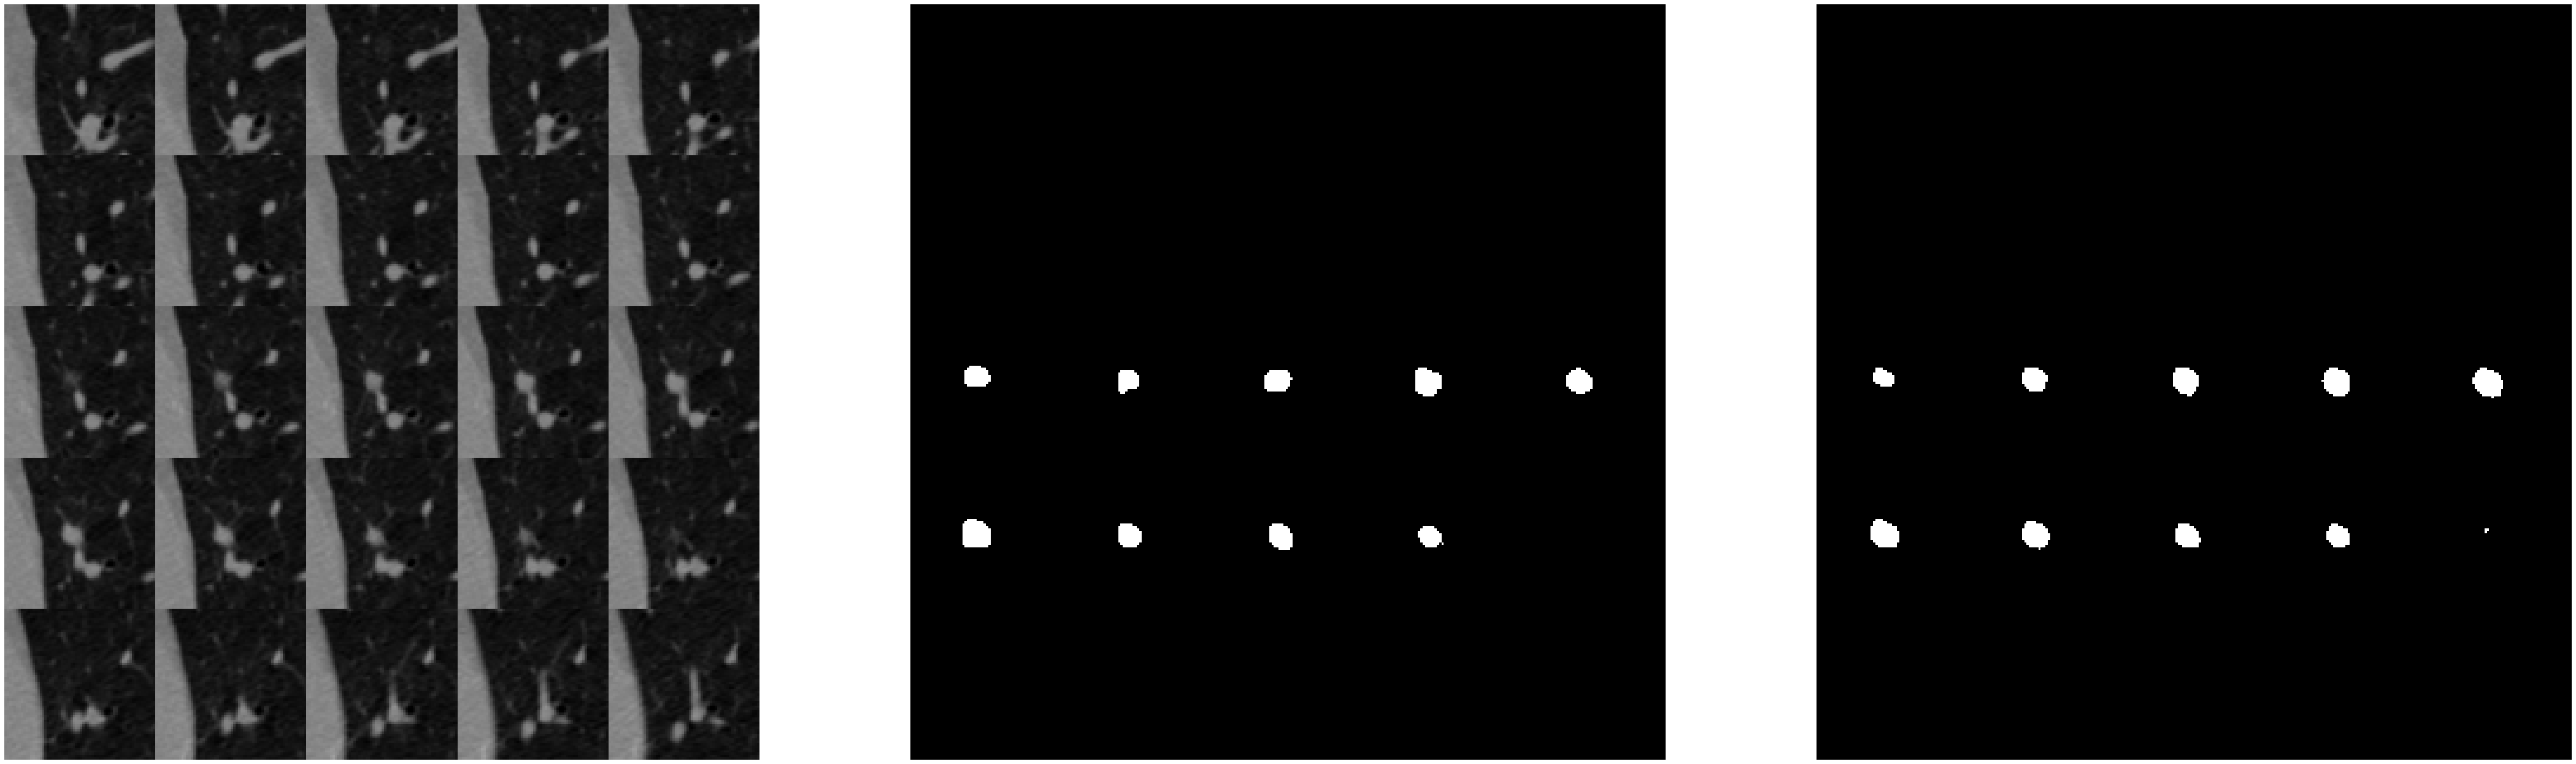

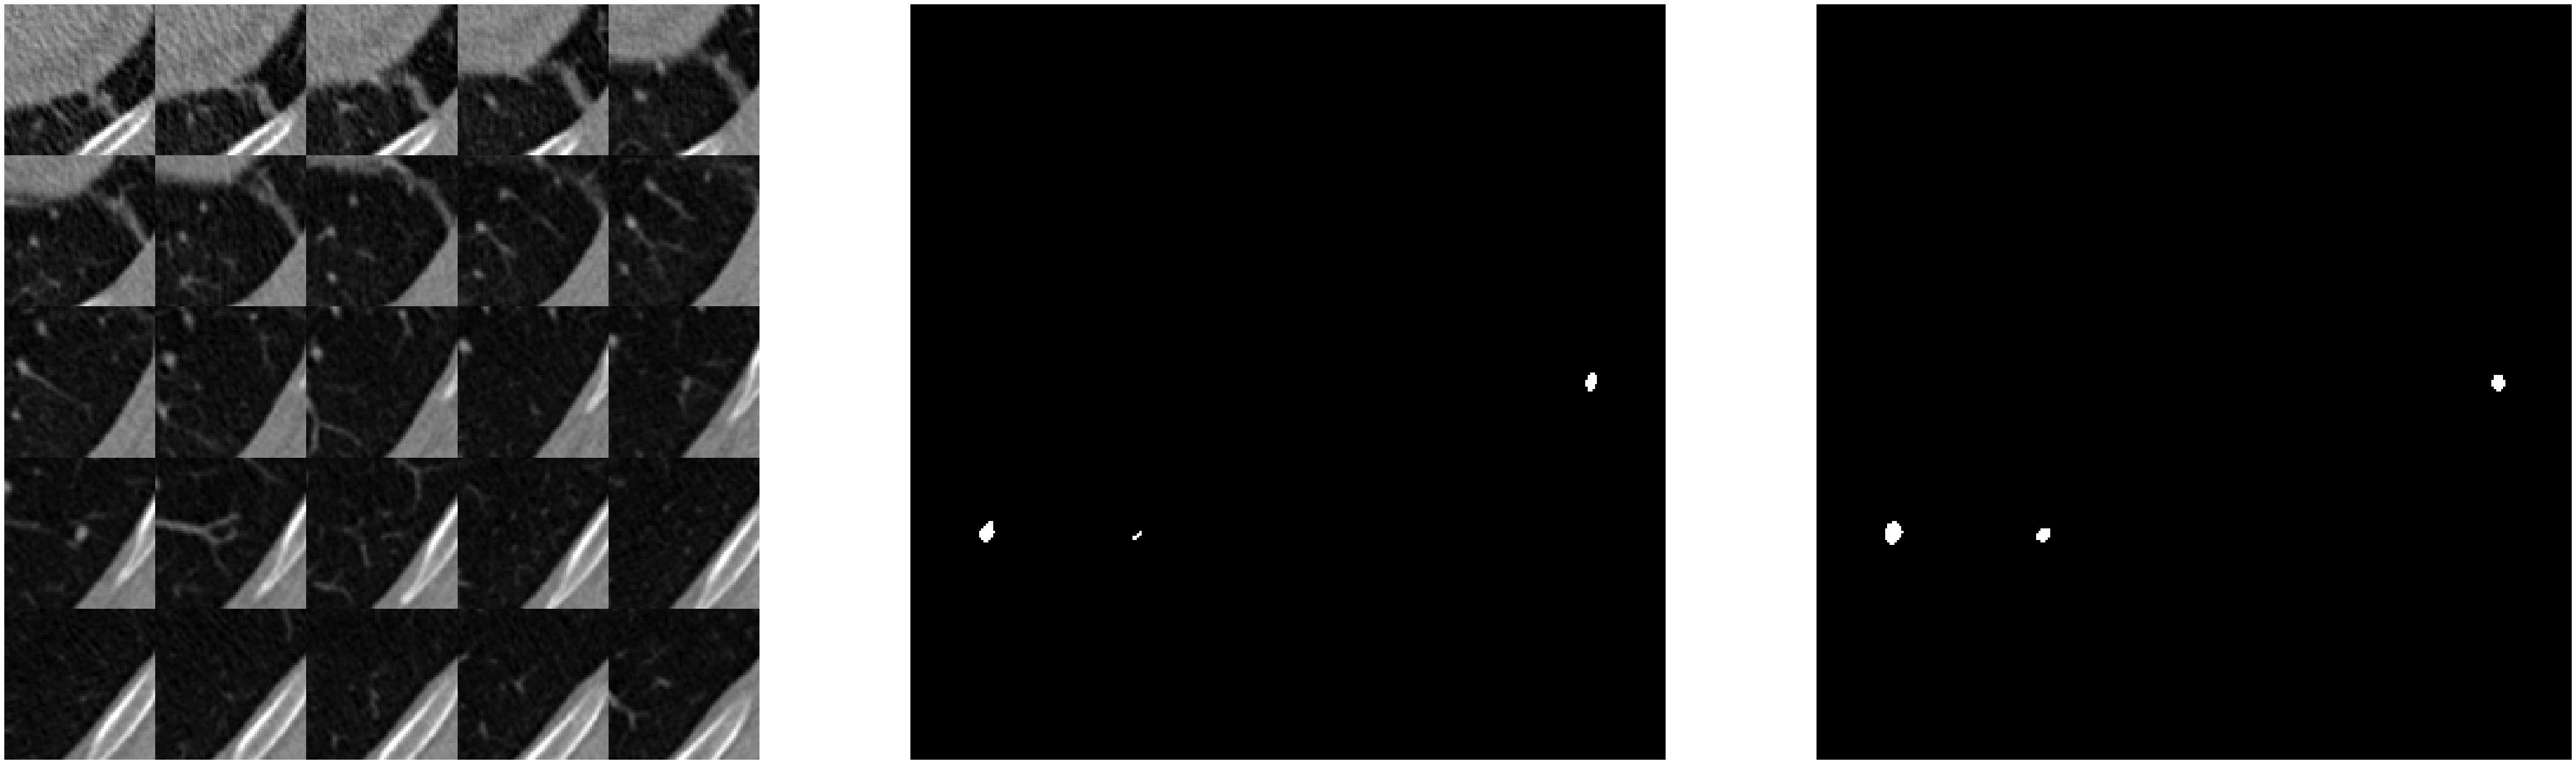

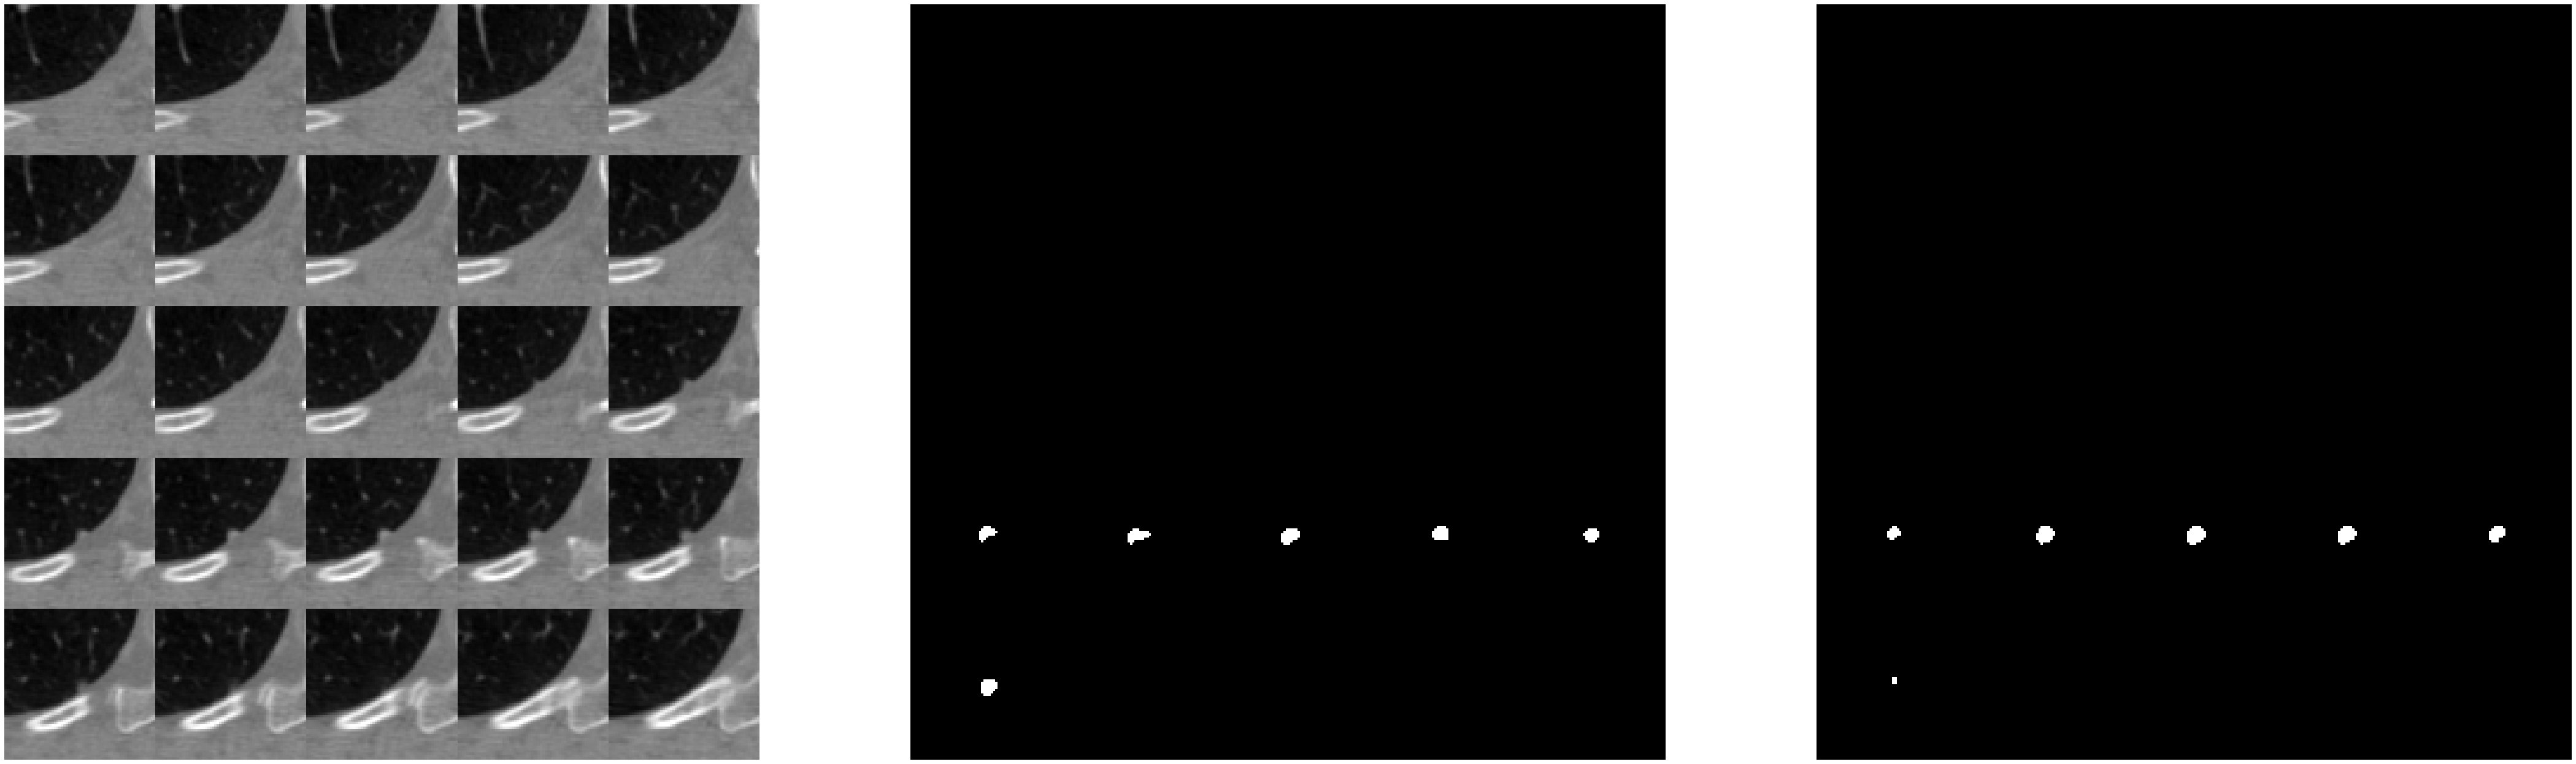

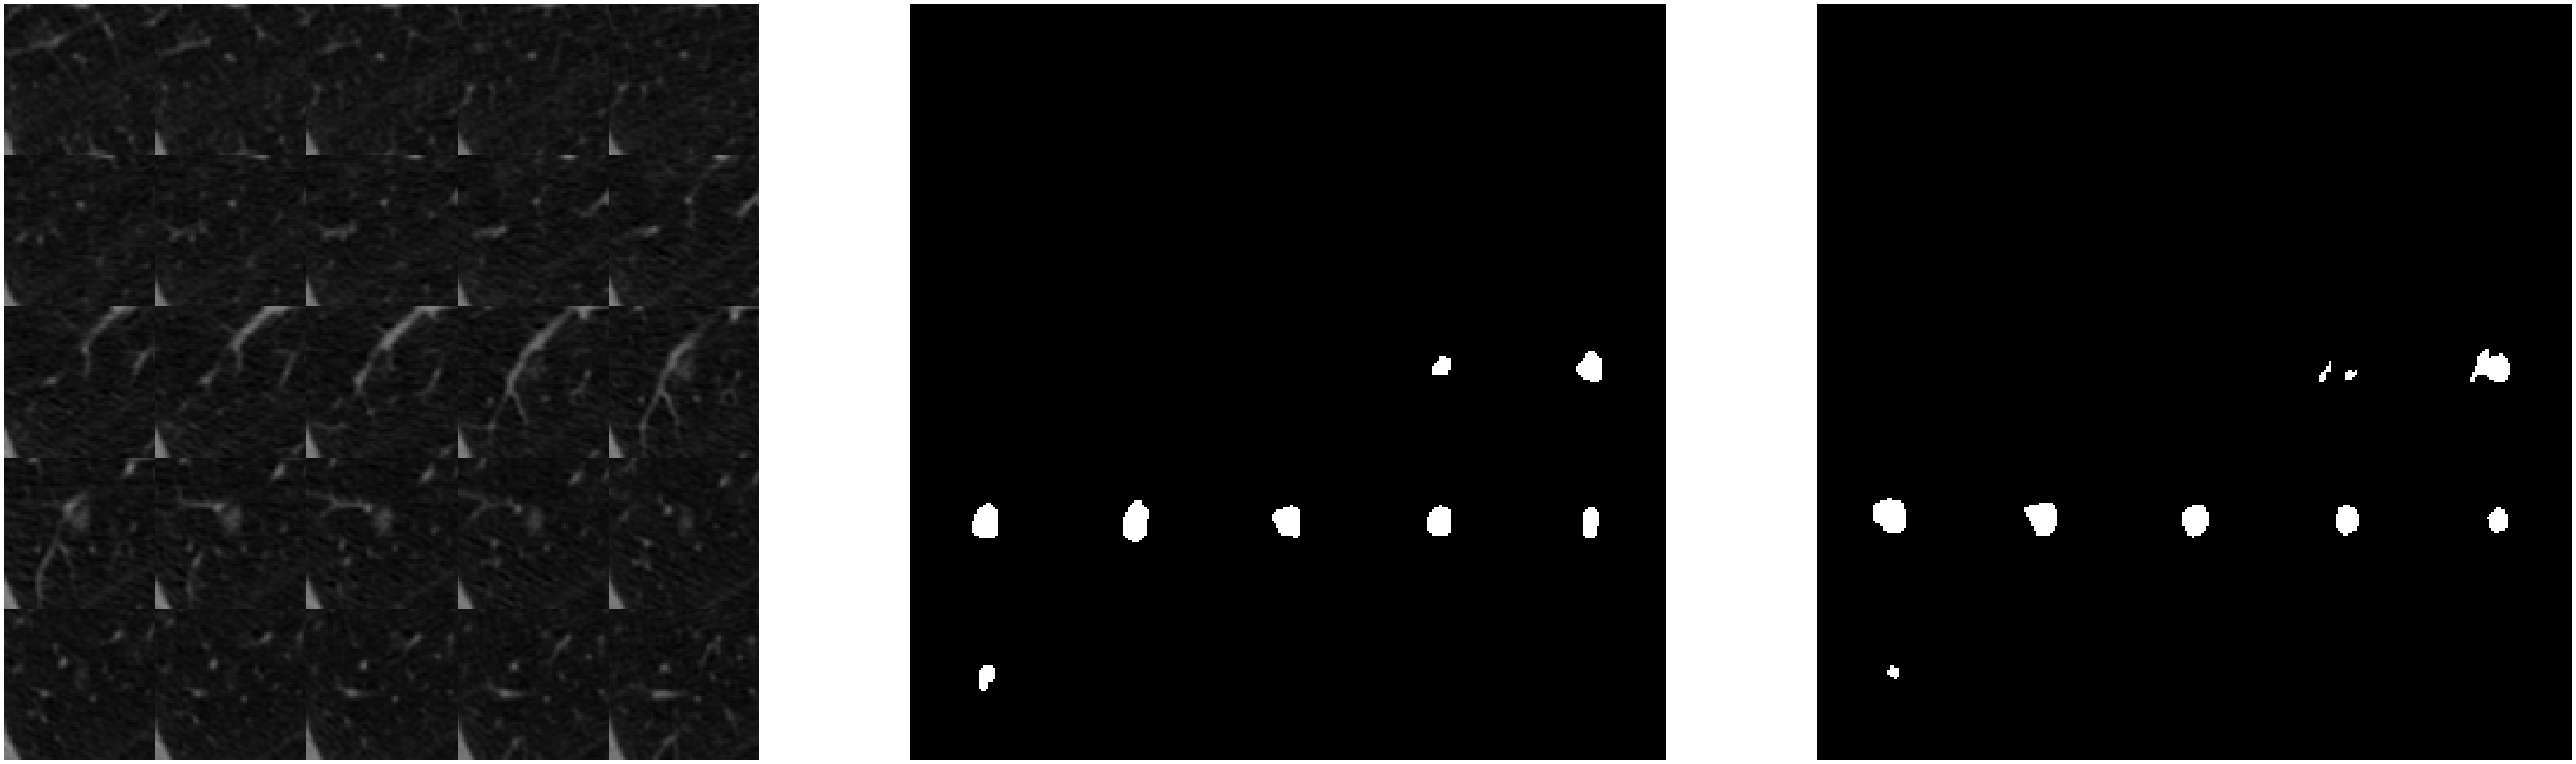

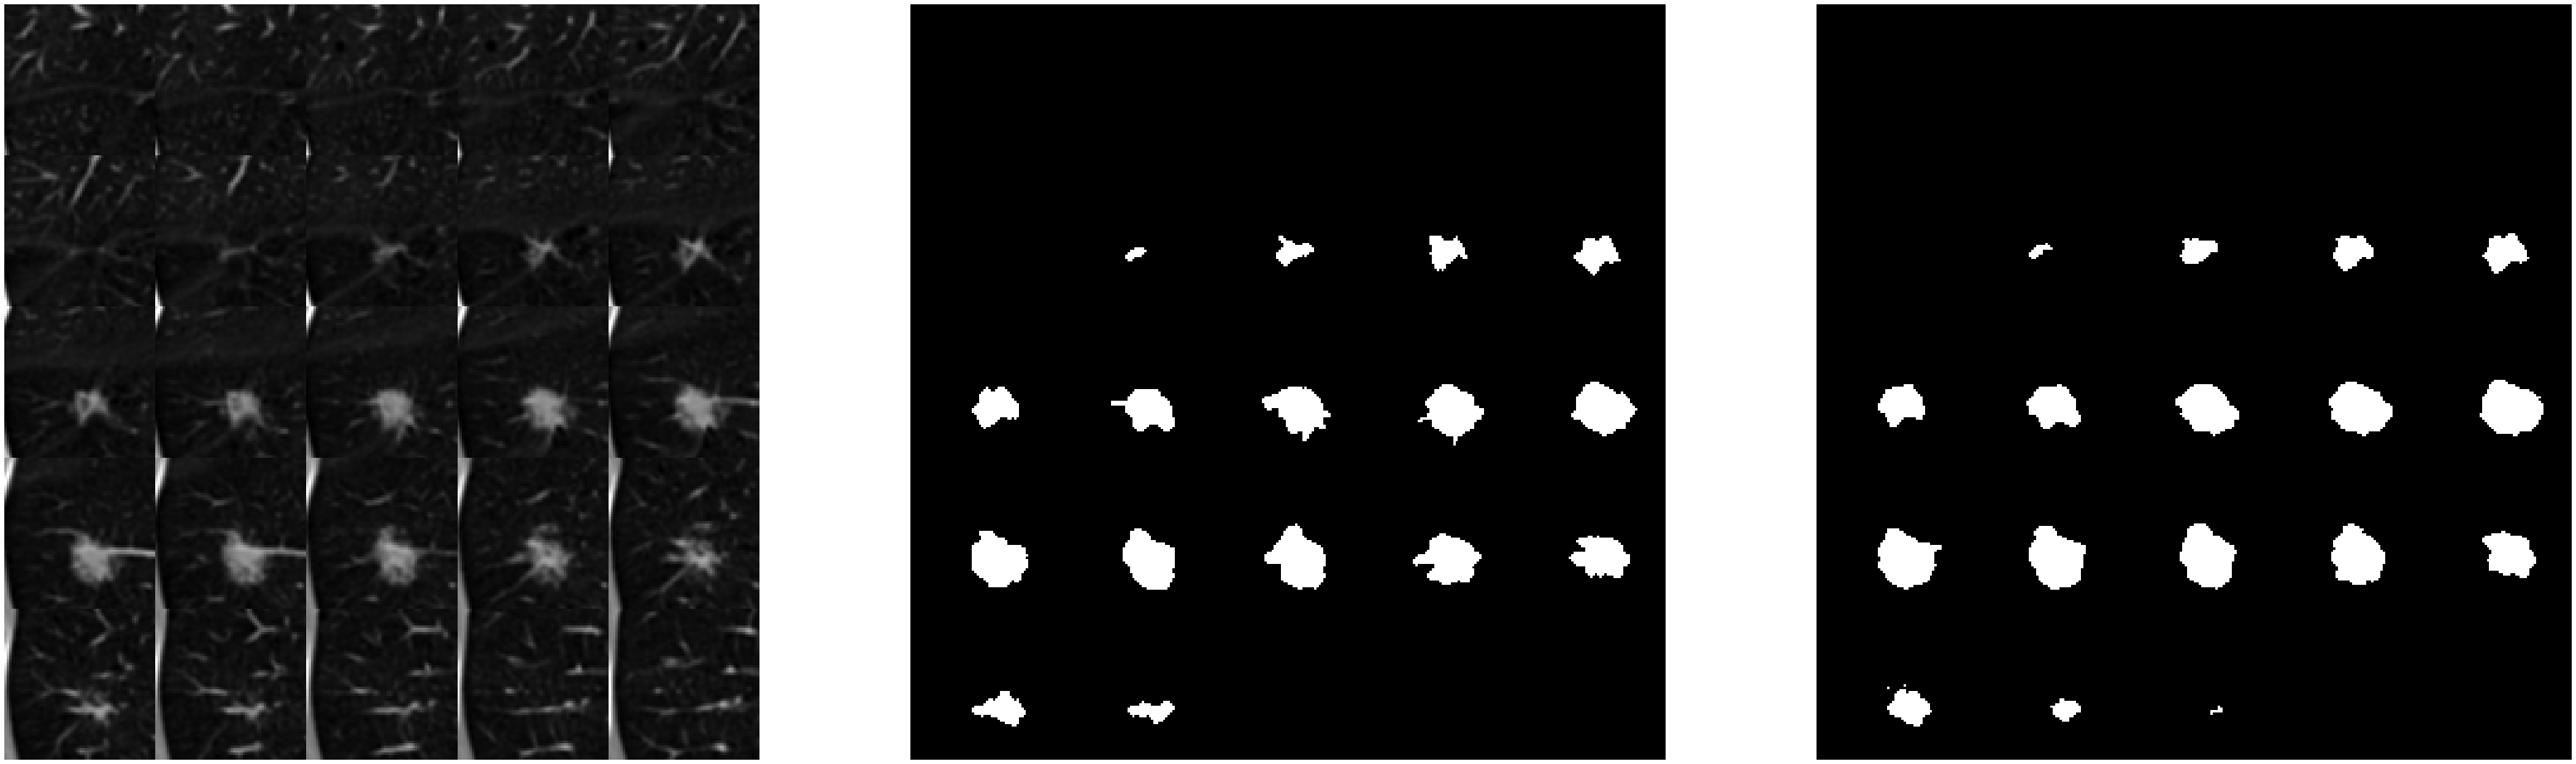

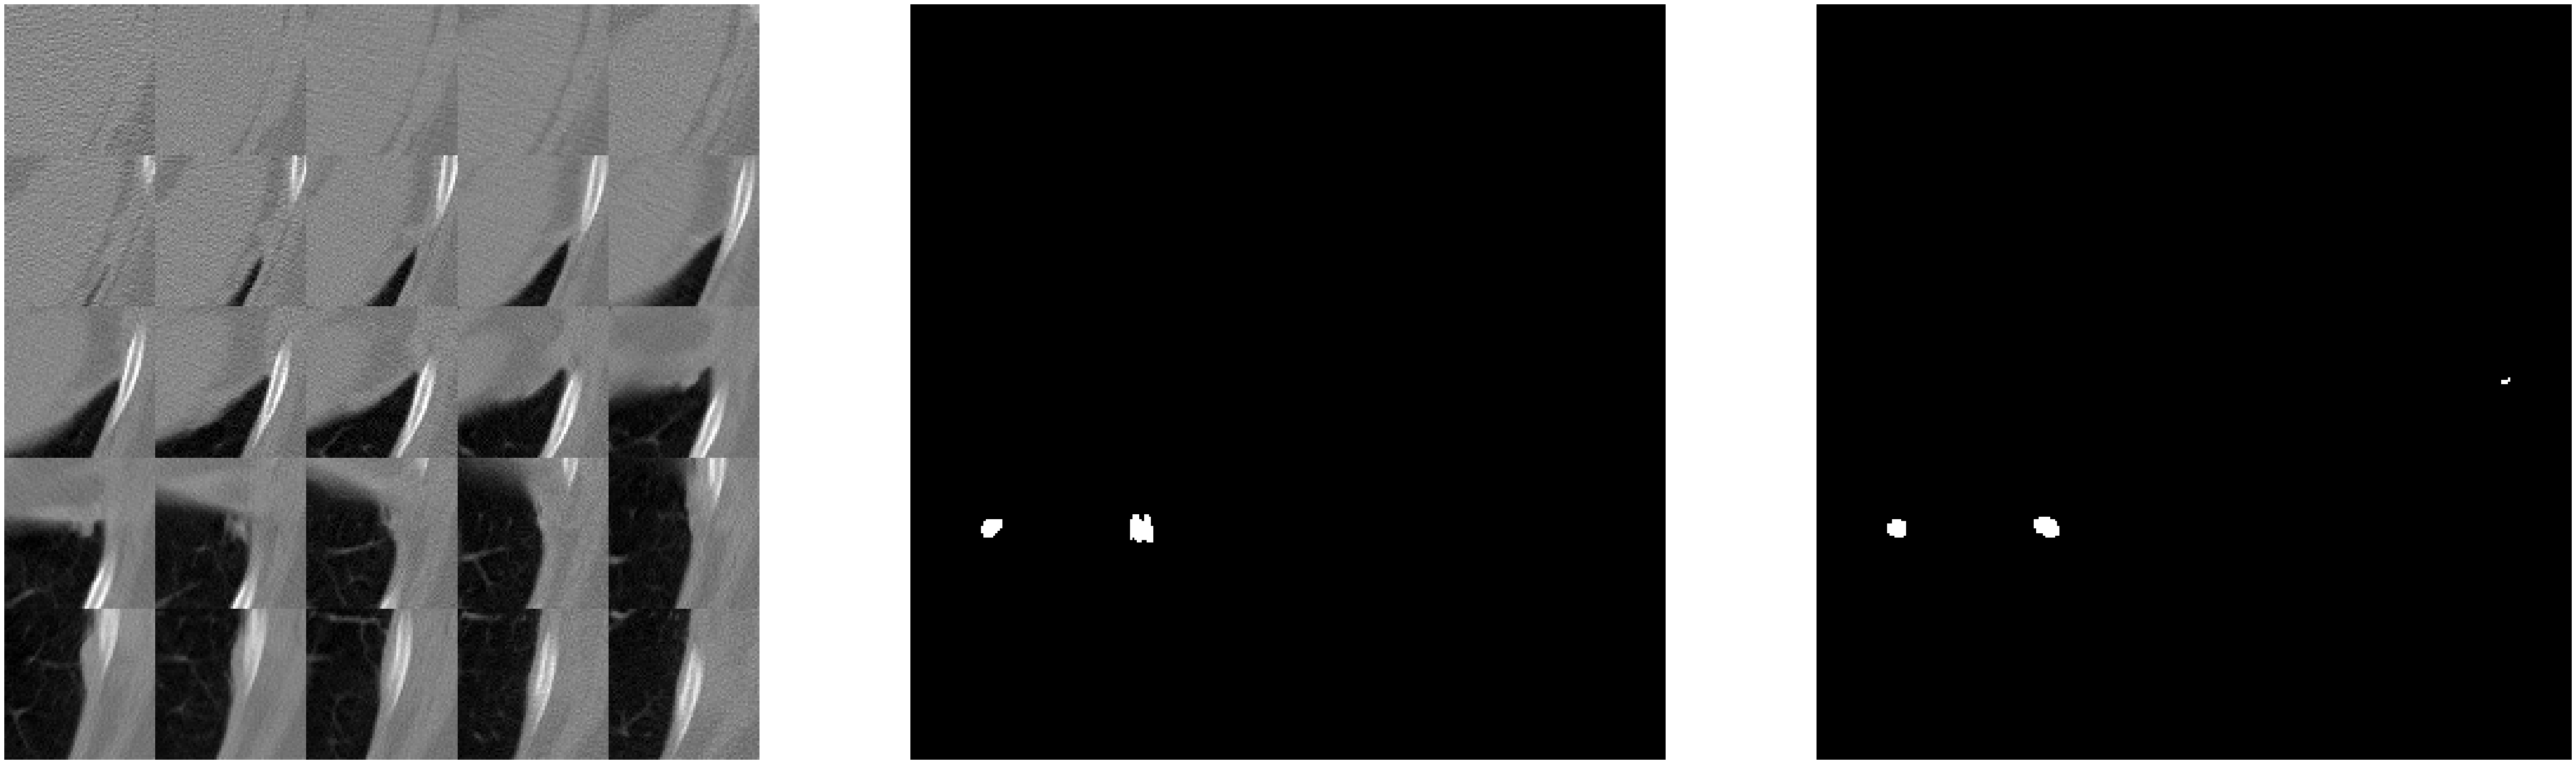

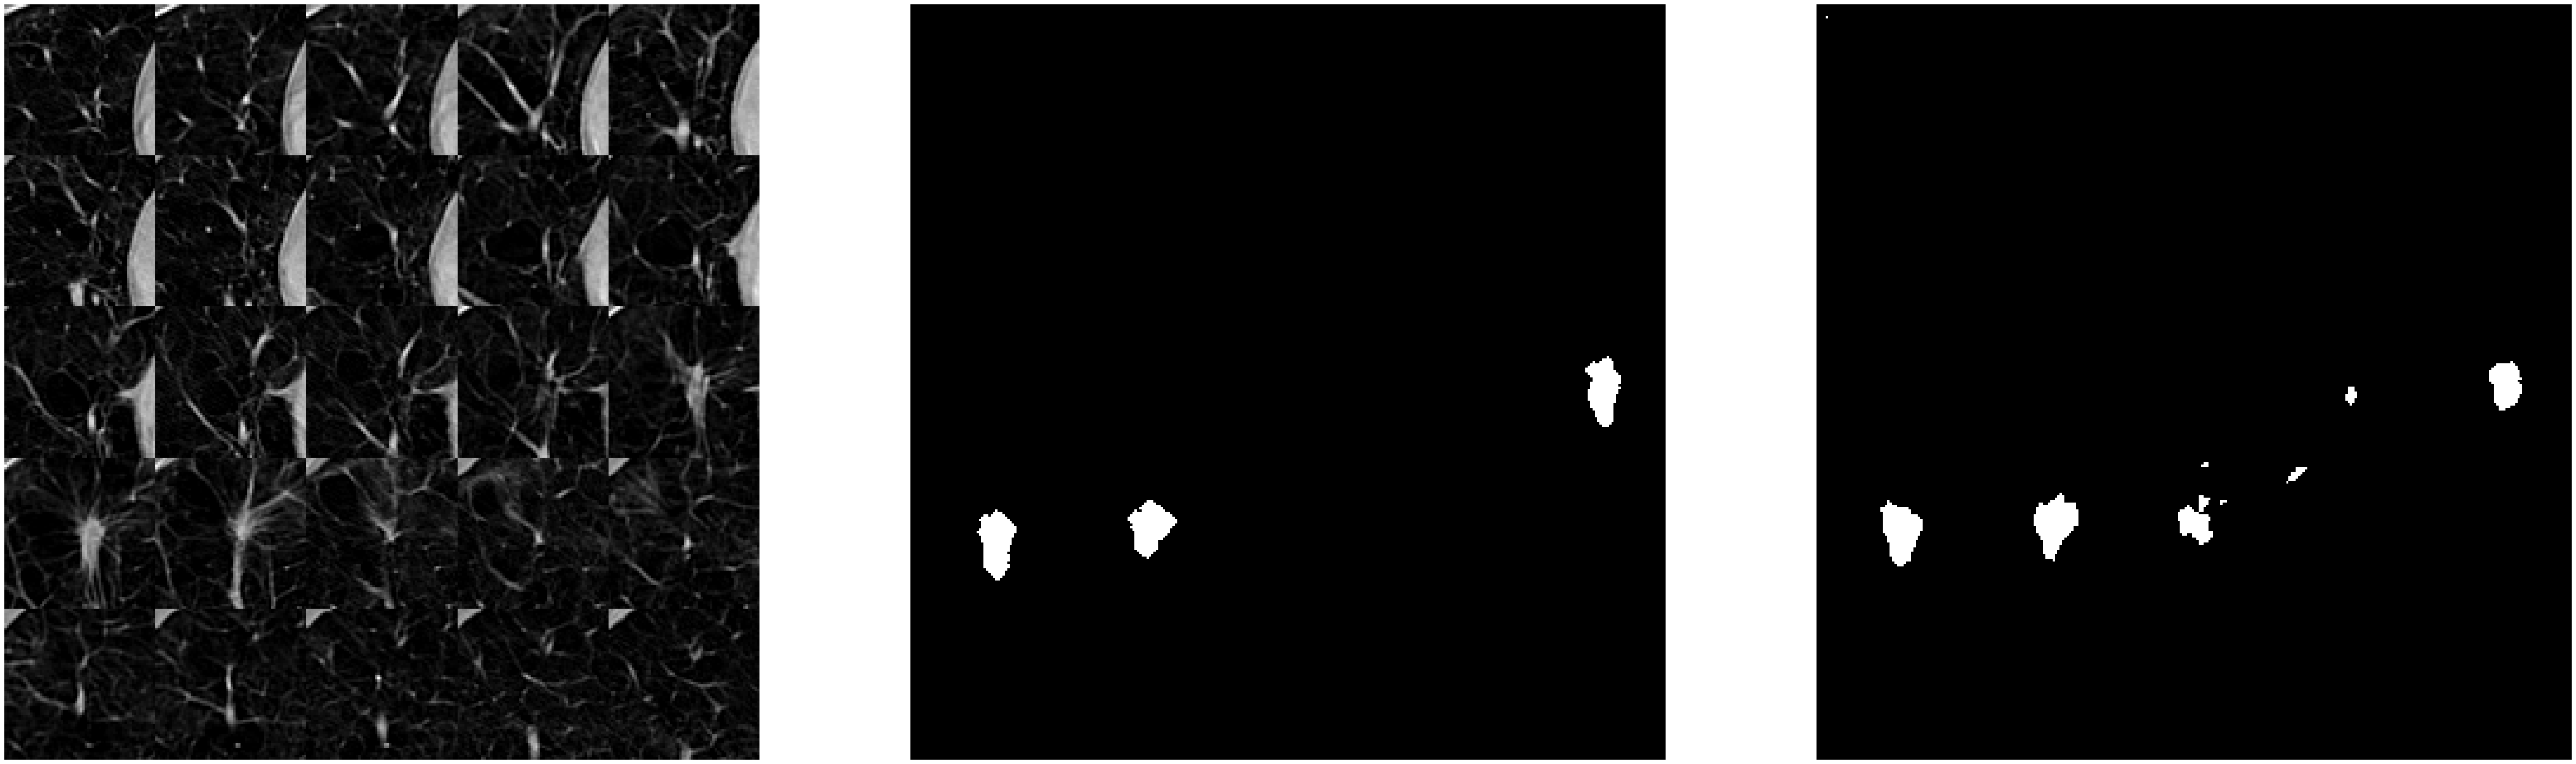

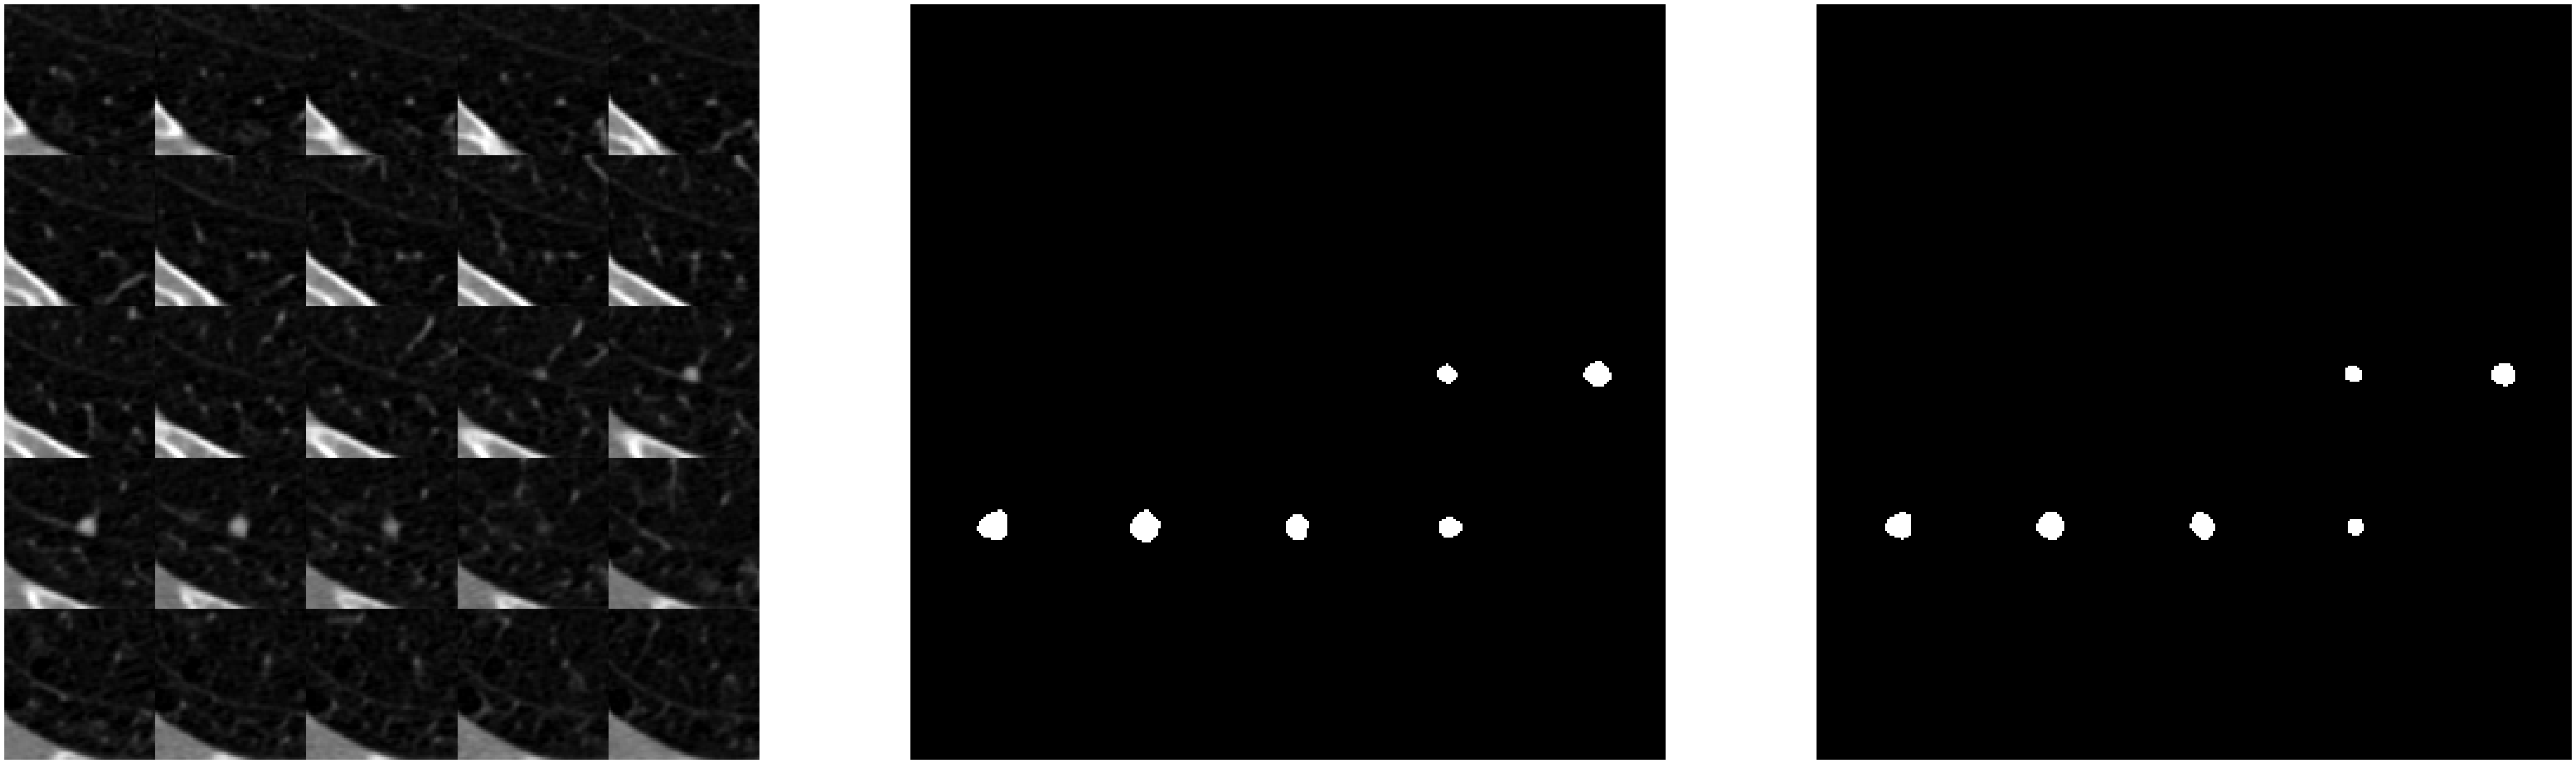

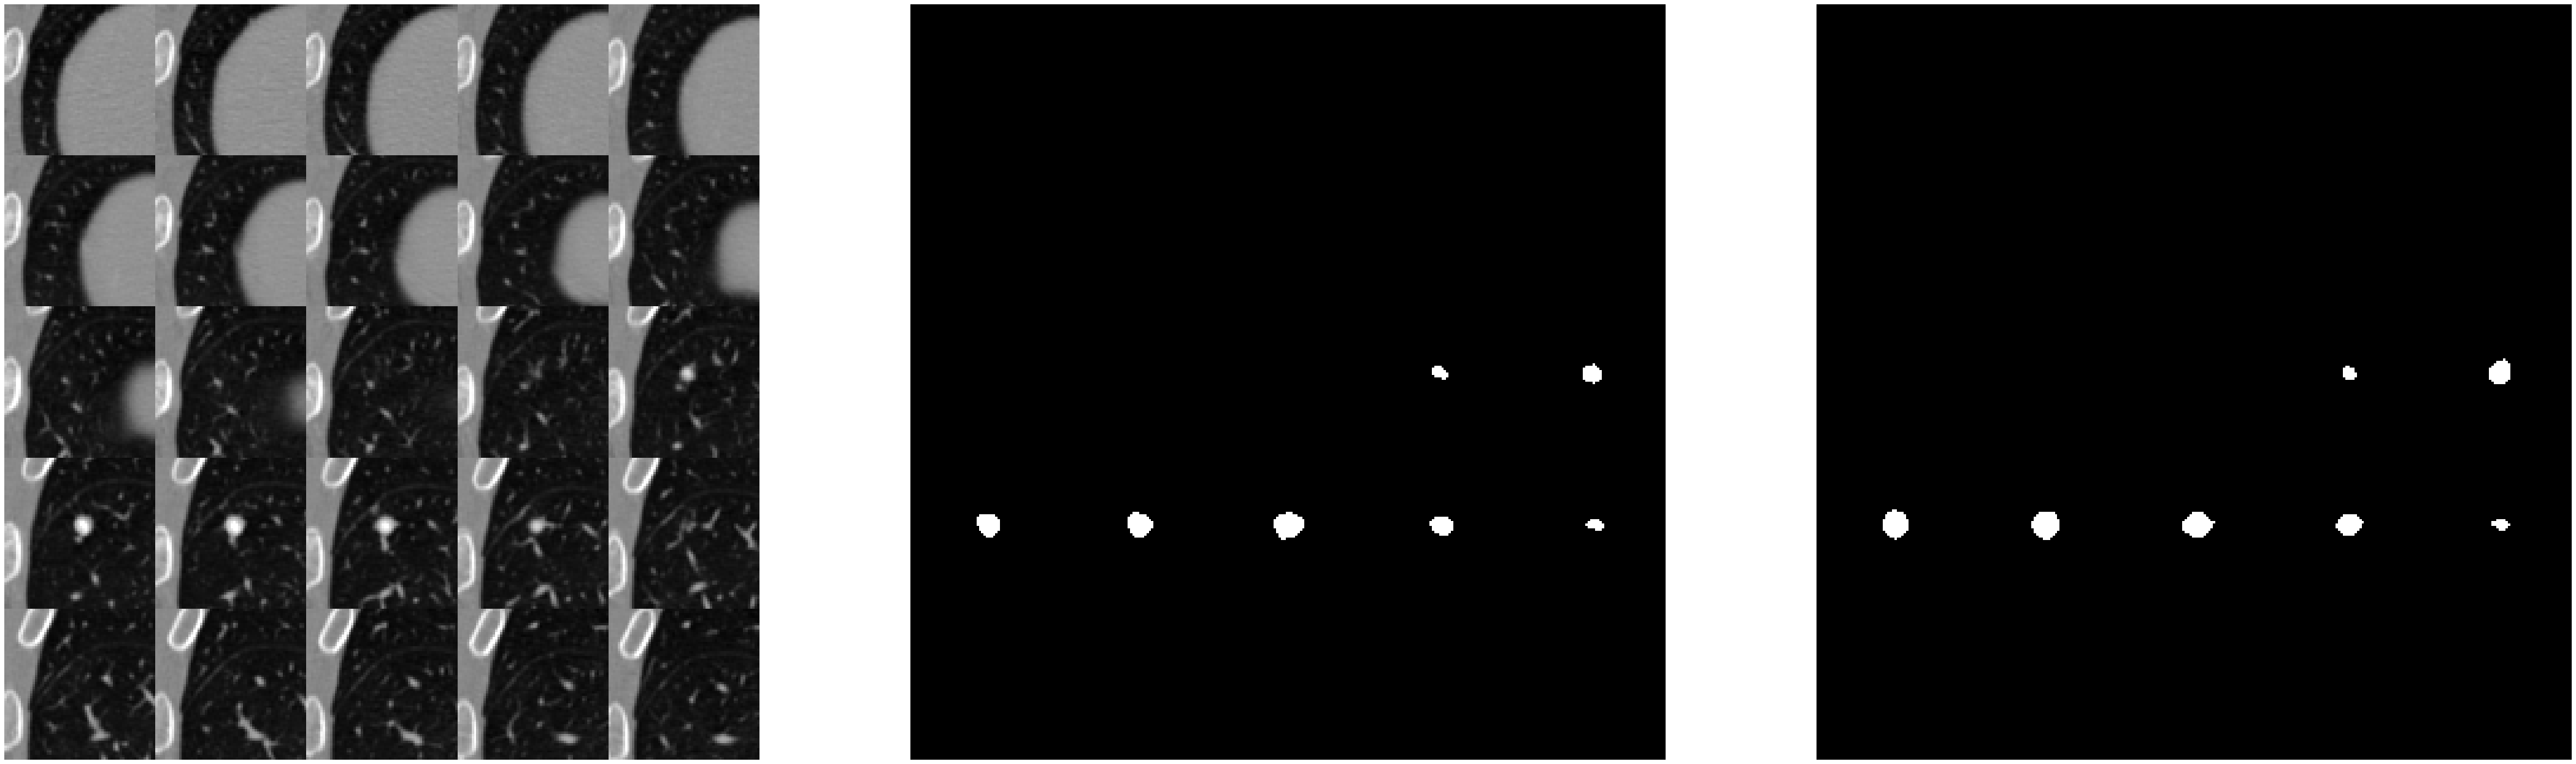

In [5]:
p_test = np.squeeze(p_test)
for i in range(0, x_test.shape[0], 80):
    plot_image_truth_prediction(x_test[i], y_test[i], p_test[i], rows=5, cols=5)